In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import figure

import sys
sys.setrecursionlimit(1000000)

In [2]:

!nvidia-smi

/bin/bash: /home/anwer/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Thu Nov 17 10:27:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P5    14W /  N/A |     46MiB /  6144MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+---

In [3]:
data_frame_train = pd.read_csv("../../csv_files_new_ppi/training_and_test_set/combined_prot_a_prot_b/combined_embedding_subset_train.csv")
data_frame_test = pd.read_csv("../../csv_files_new_ppi/training_and_test_set/combined_prot_a_prot_b/combined_embedding_subset_test.csv")
data_frame_val = pd.read_csv("../../csv_files_new_ppi/training_and_test_set/combined_prot_a_prot_b/combined_embedding_subset_val.csv")

In [5]:
data_frame_train

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0.028385,0.027177,0.001707,0.020168,-0.004517,0.028336,0.001413,-0.013377,0.032216,0.030635,...,-0.037687,-0.020171,-0.009614,-0.032648,-0.023692,-0.014956,-0.001067,-0.031846,0.012538,1
1,0.015617,-0.001422,-0.013470,0.006397,0.025932,-0.022813,-0.000177,-0.020818,-0.007053,0.001988,...,-0.006055,-0.026670,-0.021014,-0.002191,-0.015441,-0.039538,0.015931,-0.026638,0.001783,1
2,0.001469,0.003226,0.004131,0.047037,0.032908,0.024164,0.029622,0.009962,-0.017095,0.028200,...,-0.062237,-0.021205,-0.018034,-0.044636,-0.003901,0.002548,-0.002773,-0.059739,0.008306,1
3,0.018104,0.027533,0.002827,-0.021292,0.046611,-0.020751,0.018554,-0.046236,0.027736,-0.018294,...,-0.014451,-0.020901,-0.011621,0.030524,0.028947,-0.027071,0.007687,-0.033697,-0.008957,0
4,0.020711,0.021858,0.035493,0.064109,0.028367,0.025515,0.003727,-0.004875,-0.027814,-0.004117,...,-0.077938,-0.015088,0.019681,0.014134,-0.015882,-0.015707,0.023588,-0.047237,-0.009997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.002149,-0.005082,-0.007793,0.026073,0.034440,-0.004397,-0.006836,-0.014811,-0.006304,0.018683,...,-0.029779,0.001915,0.003734,-0.007455,-0.038037,0.004197,0.008961,-0.000200,0.006070,1
19996,0.019183,-0.001014,0.008177,0.021608,0.021657,0.020940,-0.008094,-0.014137,-0.031861,0.004255,...,-0.074985,0.019865,-0.023345,-0.061145,-0.017200,0.000358,0.020019,0.003406,-0.001012,0
19997,0.016292,0.026783,-0.000487,-0.003789,0.038305,0.001881,-0.029539,-0.001255,0.032015,0.008985,...,-0.057021,-0.008672,-0.024208,-0.076131,-0.034672,-0.019970,0.010658,-0.024751,-0.011714,0
19998,-0.030434,0.021819,0.025154,0.032020,0.003013,0.061596,-0.012900,0.001904,-0.008692,0.048690,...,-0.038546,-0.053721,-0.008590,0.037416,0.041671,-0.044147,-0.037194,-0.065800,0.031591,1


In [6]:
train_features = data_frame_train.copy()
train_labels = train_features.pop('label')
train_features = np.array(train_features)


test_features = data_frame_test.copy()
test_labels = test_features.pop('label')
test_features = np.array(test_features)

val_features = data_frame_val.copy()
val_labels = val_features.pop('label')
val_features = np.array(val_features)
        
x_train = train_features
y_train = train_labels
x_test = test_features
y_test = test_labels
x_val = val_features
y_val = val_labels 

In [7]:
# concat_train_features = []
# concat_test_features = []
# for i in train_features:

#     concat_train_features.append(i[0:1024] + i[1024:])

# for i in test_features:

#     concat_test_features.append(i[0:1024] + i[1024:])

# x_train = concat_train_features
# y_train = train_labels
# x_test = concat_test_features[0:5000]
# y_test = test_labels[0:5000]
# x_val = concat_test_features[5000:10000]
# y_val = np.array(test_labels[5000:10000])

In [10]:
x_train[0].shape

(1024,)

## 1. Creating Dataloader

In [7]:
## train data
class Data(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = Data(torch.FloatTensor(x_train), 
                       torch.FloatTensor(y_train))
## test data    
    

val_data = Data(torch.FloatTensor(x_test), 
                       torch.FloatTensor(y_test))


test_data =  Data(torch.FloatTensor(x_val), 
                       torch.FloatTensor(y_val))

In [8]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=6000,drop_last=True )
val_loader = DataLoader(dataset=val_data, batch_size=128,drop_last=True )

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Model

In [10]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
device

device(type='cuda')

In [12]:
class BertClassifier(nn.Module):
    
    def __init__(self, embed_dim =1024):
        super(BertClassifier,self).__init__()
     
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(embed_dim,1024)
        self.bn1 = nn.BatchNorm1d(num_features=1024)
        self.fc1_1 = nn.Linear(1024,512)
#         self.fc2 = nn.Linear(512,256)
        
        self.fc3 = nn.Linear(512,64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc4 = nn.Linear(64,32)
        
        self.fc5 = nn.Linear(32,16)
        self.fc6 = nn.Linear(16,8)
        self.fc7 = nn.Linear(8,1)

    
    def forward(self, inputs):
        
       
        # print(output)
        output_1 = self.relu(self.fc1(inputs))
        output_1 = self.bn1(output_1)
        output_1_1 = self.relu(self.fc1_1(output_1))
    
        output_2 = self.relu(self.fc3(output_1_1))
        output_2  = self.bn2(output_2)
        output_3 = self.relu(self.fc4(output_2))
        output_4 = self.relu(self.fc5(output_3))
        output_5 = self.relu(self.fc6(output_4))
        output = self.fc7(output_5)

        return output

# 

In [13]:
def initilize_model(learning_rate=0.001):
    """Instantiate a CNN model and an optimizer."""

    model = BertClassifier()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Send model to `device` (GPU/CPU)
    model.to(device)
    model= nn.DataParallel(model,device_ids = [0])

    
    return model

model = initilize_model()


loss_fn = nn.BCEWithLogitsLoss()

In [14]:
print(model)

DataParallel(
  (module): BertClassifier(
    (relu): ReLU()
    (fc1): Linear(in_features=1024, out_features=1024, bias=True)
    (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1_1): Linear(in_features=1024, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=64, bias=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=16, bias=True)
    (fc6): Linear(in_features=16, out_features=8, bias=True)
    (fc7): Linear(in_features=8, out_features=1, bias=True)
  )
)


## 3. Training

In [34]:
import random
import time
from tqdm import tqdm
loss_fn = nn.BCEWithLogitsLoss()
def train(model, optimizer, train_dataloader, val_dataloader = None, epochs =10):
    
    best_accuracy = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Start training...\n")
    train_loss_list = []
    val_loss_list = []    
    # for param in model.bert.parameters():
    #     param.requires_grad = False
    for epoch_i in range(1,epochs+1):
        
        total_loss = 0
        model.train()
        
        for step,batch in tqdm(enumerate(train_dataloader)):
            
            inputs, b_labels = tuple(t.to(device) for t in batch)
            
            # b_input_ids = b_input_ids.reshape((1,24,1000)).squeeze(0)
            # b_attn_masks = b_attn_masks.reshape((1,24,1000)).squeeze(0)
            b_labels = b_labels.reshape((1,128,1)).squeeze(0)
            # print(b_input_1)
            model.zero_grad()
            
            logits = model(inputs)
            
        #     preds = torch.round(torch.sigmoid(logits))
        # # print(preds,b_labels)
        #     accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100
        #     print(accuracy)
            
#             print(b_labels)
           
            loss = loss_fn(logits,b_labels.float()) 
            
            total_loss += loss.item()
            
            loss.mean().backward()
            
            optimizer.step()
               
        avg_train_loss = total_loss / len(train_dataloader)
        train_loss_list.append(avg_train_loss)
    
        if val_dataloader is not None:
                
                val_loss, val_accuracy = evaluate(model, val_dataloader)
                val_loss_list.append(val_loss)
                   
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    torch.save({
                        'epoch': epoch_i + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss_fn,
                        }, 'best_model_trained_fc_v2.pth')

                # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience = 3)
                # scheduler.step(val_accuracy)
        print(f"Epoch: {epoch_i} | Training Loss: {avg_train_loss}  | Validation Loss: {val_loss}  | Accuracy: {val_accuracy:.2f}")
        with open('result.txt', 'a') as f:
            print(f"Epoch: {epoch_i} | Training Loss: {avg_train_loss}  | Validation Loss: {val_loss}  | Accuracy: {val_accuracy:.2f}", file=f) 
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    return train_loss_list,val_loss_list

            
   


def evaluate(model,val_dataloader):
    
    model.eval()
    
    val_accuracy = []
    val_loss = []
    for batch in tqdm(val_dataloader):
        # Load batch to GPU
        inputs, b_labels = tuple(t.to(device) for t in batch)
        
        # b_input_ids = b_input_ids.reshape((1,24,1000)).squeeze(0)
        # b_attn_masks = b_attn_masks.reshape((1,24,1000)).squeeze(0)
        b_labels = b_labels.reshape((1,128,1)).squeeze(0)
        with torch.no_grad():
                logits = model(inputs)
        
        
        
        
        loss = loss_fn(logits, b_labels.float())
        
        val_loss.append(loss.item())
# # model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
# for i in tqdm(train_dataloader):
#     print(i)
        preds = torch.round(torch.sigmoid(logits))
        # print(preds,b_labels)
        accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100

        val_accuracy.append(accuracy)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy 

In [36]:
optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-09,weight_decay=0.01,amsgrad=True)
# optimizer = torch.optim.SGD(model.parameters(), nesterov = True, lr=0.001, momentum=0.9)

In [38]:
train_loss_list,val_loss_list =train(model, optimizer,train_loader,val_loader,epochs=500)

Start training...



156it [00:01, 113.44it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.71it/s]


Epoch: 1 | Training Loss: 0.3403764763512673  | Validation Loss: 0.9592381586199221  | Accuracy: 60.44


156it [00:01, 116.60it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 196.25it/s]


Epoch: 2 | Training Loss: 0.34456089186744815  | Validation Loss: 0.8348048173862955  | Accuracy: 61.77


156it [00:01, 117.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.16it/s]


Epoch: 3 | Training Loss: 0.33878208267001003  | Validation Loss: 0.8766778707504272  | Accuracy: 61.19


156it [00:01, 111.52it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.10it/s]


Epoch: 4 | Training Loss: 0.3306764451165994  | Validation Loss: 0.8614903649558192  | Accuracy: 61.77


156it [00:01, 114.44it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 172.81it/s]


Epoch: 5 | Training Loss: 0.3322620838880539  | Validation Loss: 0.8825118243694305  | Accuracy: 61.12


156it [00:01, 119.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.88it/s]


Epoch: 6 | Training Loss: 0.33087288569181394  | Validation Loss: 1.0292506671470145  | Accuracy: 60.44


156it [00:01, 119.33it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.88it/s]


Epoch: 7 | Training Loss: 0.3282842022868303  | Validation Loss: 1.0061823349931966  | Accuracy: 60.09


156it [00:01, 115.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.16it/s]


Epoch: 8 | Training Loss: 0.3315234797505232  | Validation Loss: 0.925783643256063  | Accuracy: 60.95


156it [00:01, 123.95it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.71it/s]


Epoch: 9 | Training Loss: 0.32502738214456117  | Validation Loss: 0.9472397060497947  | Accuracy: 61.75


156it [00:01, 117.93it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.89it/s]


Epoch: 10 | Training Loss: 0.32151892370520496  | Validation Loss: 0.9739444761172585  | Accuracy: 60.07


156it [00:01, 117.15it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.21it/s]


Epoch: 11 | Training Loss: 0.316034158739524  | Validation Loss: 0.8842418362265048  | Accuracy: 62.23


156it [00:01, 126.24it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.07it/s]


Epoch: 12 | Training Loss: 0.31895597412800175  | Validation Loss: 0.8448915922123453  | Accuracy: 62.92


156it [00:01, 117.87it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.07it/s]


Epoch: 13 | Training Loss: 0.31860243099240154  | Validation Loss: 0.9678939697535142  | Accuracy: 61.92


156it [00:01, 117.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.05it/s]


Epoch: 14 | Training Loss: 0.3168810967069406  | Validation Loss: 0.9472176821335502  | Accuracy: 60.89


156it [00:01, 125.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.62it/s]


Epoch: 15 | Training Loss: 0.3179882574730959  | Validation Loss: 0.7945653005786564  | Accuracy: 63.38


156it [00:01, 119.53it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.45it/s]


Epoch: 16 | Training Loss: 0.3112118511627882  | Validation Loss: 0.9555657791054767  | Accuracy: 62.36


156it [00:01, 118.44it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.94it/s]


Epoch: 17 | Training Loss: 0.31595756466954183  | Validation Loss: 1.096051424741745  | Accuracy: 57.85


156it [00:01, 122.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.74it/s]


Epoch: 18 | Training Loss: 0.3088195273318352  | Validation Loss: 0.8223497064217277  | Accuracy: 62.62


156it [00:01, 114.58it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.73it/s]


Epoch: 19 | Training Loss: 0.3066819454423892  | Validation Loss: 0.8528497180213099  | Accuracy: 63.30


156it [00:01, 113.80it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.49it/s]


Epoch: 20 | Training Loss: 0.31391394873842215  | Validation Loss: 0.8736322457375734  | Accuracy: 62.55


156it [00:01, 124.77it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.75it/s]


Epoch: 21 | Training Loss: 0.31375771569900024  | Validation Loss: 0.894475545572198  | Accuracy: 62.25


156it [00:01, 113.52it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.06it/s]


Epoch: 22 | Training Loss: 0.3103099460594165  | Validation Loss: 0.971970602222111  | Accuracy: 59.87


156it [00:01, 113.24it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.97it/s]


Epoch: 23 | Training Loss: 0.3074743171723989  | Validation Loss: 0.8924654774043871  | Accuracy: 61.80


156it [00:01, 116.98it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 156.25it/s]


Epoch: 24 | Training Loss: 0.309400717035318  | Validation Loss: 0.9030547401179438  | Accuracy: 61.58


156it [00:01, 108.21it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.40it/s]


Epoch: 25 | Training Loss: 0.3034965167633998  | Validation Loss: 0.9933967849482661  | Accuracy: 59.83


156it [00:01, 115.51it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.08it/s]


Epoch: 26 | Training Loss: 0.30610062869695515  | Validation Loss: 1.0270932692548502  | Accuracy: 59.09


156it [00:01, 121.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.62it/s]


Epoch: 27 | Training Loss: 0.30244163672129315  | Validation Loss: 0.9257538137228593  | Accuracy: 60.80


156it [00:01, 117.15it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.18it/s]


Epoch: 28 | Training Loss: 0.30208317773082316  | Validation Loss: 0.9053891625093378  | Accuracy: 61.16


156it [00:01, 115.50it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.28it/s]


Epoch: 29 | Training Loss: 0.30051937718421984  | Validation Loss: 0.9233581864315531  | Accuracy: 61.12


156it [00:01, 118.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 168.99it/s]


Epoch: 30 | Training Loss: 0.30096590108214283  | Validation Loss: 0.9399455435897993  | Accuracy: 62.21


156it [00:01, 118.63it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.42it/s]


Epoch: 31 | Training Loss: 0.29655612880984944  | Validation Loss: 0.9351140260696411  | Accuracy: 60.44


156it [00:01, 118.04it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.30it/s]


Epoch: 32 | Training Loss: 0.29955891357400477  | Validation Loss: 0.9039816662021305  | Accuracy: 61.60


156it [00:01, 115.60it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.86it/s]


Epoch: 33 | Training Loss: 0.29729527741288525  | Validation Loss: 0.8886981463950613  | Accuracy: 60.53


156it [00:01, 125.48it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.56it/s]


Epoch: 34 | Training Loss: 0.293020282800381  | Validation Loss: 0.9985058242860048  | Accuracy: 60.41


156it [00:01, 114.30it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.79it/s]


Epoch: 35 | Training Loss: 0.2971009043737864  | Validation Loss: 0.9415324058221735  | Accuracy: 61.11


156it [00:01, 116.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.04it/s]


Epoch: 36 | Training Loss: 0.2950995568281565  | Validation Loss: 0.8964919992115187  | Accuracy: 60.11


156it [00:01, 121.43it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.57it/s]


Epoch: 37 | Training Loss: 0.29655076133517116  | Validation Loss: 0.9194274000499559  | Accuracy: 62.65


156it [00:01, 113.26it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.53it/s]


Epoch: 38 | Training Loss: 0.2924586658676465  | Validation Loss: 0.9836738550144694  | Accuracy: 60.94


156it [00:01, 116.33it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.40it/s]


Epoch: 39 | Training Loss: 0.2939371985311692  | Validation Loss: 0.9012859385946522  | Accuracy: 62.38


156it [00:01, 126.18it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.56it/s]


Epoch: 40 | Training Loss: 0.29270427311078095  | Validation Loss: 0.9082523079022117  | Accuracy: 60.26


156it [00:01, 116.08it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.44it/s]


Epoch: 41 | Training Loss: 0.29171009371295953  | Validation Loss: 0.9165322353010592  | Accuracy: 61.65


156it [00:01, 118.40it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.92it/s]


Epoch: 42 | Training Loss: 0.2890014888193363  | Validation Loss: 0.9904261918171592  | Accuracy: 61.45


156it [00:01, 126.65it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.88it/s]


Epoch: 43 | Training Loss: 0.28680337860416144  | Validation Loss: 0.9970002744508826  | Accuracy: 61.09


156it [00:01, 117.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.19it/s]


Epoch: 44 | Training Loss: 0.29312611256654447  | Validation Loss: 1.0177267958288607  | Accuracy: 60.84


156it [00:01, 116.83it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.15it/s]


Epoch: 45 | Training Loss: 0.2874452307438239  | Validation Loss: 0.9672046809092812  | Accuracy: 61.51


156it [00:01, 115.89it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 185.61it/s]


Epoch: 46 | Training Loss: 0.2841960238531614  | Validation Loss: 0.9137843834317249  | Accuracy: 61.62


156it [00:01, 113.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.03it/s]


Epoch: 47 | Training Loss: 0.28155266761015624  | Validation Loss: 1.0240818819274073  | Accuracy: 60.46


156it [00:01, 116.06it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.68it/s]


Epoch: 48 | Training Loss: 0.28715256601572037  | Validation Loss: 0.9633189167665399  | Accuracy: 59.78


156it [00:01, 114.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 182.18it/s]


Epoch: 49 | Training Loss: 0.28427219935334647  | Validation Loss: 0.9688015930030657  | Accuracy: 60.58


156it [00:01, 115.36it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.64it/s]


Epoch: 50 | Training Loss: 0.2834438434204994  | Validation Loss: 1.1201289257277613  | Accuracy: 59.09


156it [00:01, 113.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.26it/s]


Epoch: 51 | Training Loss: 0.29233409397495097  | Validation Loss: 0.9394673096097034  | Accuracy: 62.43


156it [00:01, 116.14it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 159.08it/s]


Epoch: 52 | Training Loss: 0.28394215802351636  | Validation Loss: 0.957710404758868  | Accuracy: 61.21


156it [00:01, 120.60it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.83it/s]


Epoch: 53 | Training Loss: 0.28452954087883997  | Validation Loss: 0.9584518839483676  | Accuracy: 60.39


156it [00:01, 105.79it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.49it/s]


Epoch: 54 | Training Loss: 0.2831738634178272  | Validation Loss: 0.9404290642427362  | Accuracy: 61.72


156it [00:01, 102.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.18it/s]


Epoch: 55 | Training Loss: 0.27922901339255846  | Validation Loss: 0.98880721045577  | Accuracy: 60.50


156it [00:01, 108.01it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.94it/s]


Epoch: 56 | Training Loss: 0.2768575857656124  | Validation Loss: 1.073735156784887  | Accuracy: 59.85


156it [00:01, 108.91it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 141.87it/s]


Epoch: 57 | Training Loss: 0.27847185855110484  | Validation Loss: 1.1659092242303102  | Accuracy: 58.68


156it [00:01, 104.10it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.25it/s]


Epoch: 58 | Training Loss: 0.2855372556891197  | Validation Loss: 0.9155871829260951  | Accuracy: 61.84


156it [00:01, 112.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.95it/s]


Epoch: 59 | Training Loss: 0.2797323319201286  | Validation Loss: 1.008399337530136  | Accuracy: 60.67


156it [00:01, 110.26it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.73it/s]


Epoch: 60 | Training Loss: 0.2813904036123019  | Validation Loss: 0.9583437352076821  | Accuracy: 60.48


156it [00:01, 111.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.10it/s]


Epoch: 61 | Training Loss: 0.27860158662765455  | Validation Loss: 0.9725695485654084  | Accuracy: 60.99


156it [00:01, 118.49it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 142.00it/s]


Epoch: 62 | Training Loss: 0.28158168580669624  | Validation Loss: 0.9942958186502042  | Accuracy: 61.36


156it [00:01, 111.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.67it/s]


Epoch: 63 | Training Loss: 0.2721622209900465  | Validation Loss: 1.0381131379500679  | Accuracy: 58.98


156it [00:01, 109.17it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.46it/s]


Epoch: 64 | Training Loss: 0.27526551217604905  | Validation Loss: 1.0345028677712316  | Accuracy: 59.75


156it [00:01, 115.33it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.02it/s]


Epoch: 65 | Training Loss: 0.2789220463197965  | Validation Loss: 0.9438153129556904  | Accuracy: 61.14


156it [00:01, 112.79it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.56it/s]


Epoch: 66 | Training Loss: 0.2823777581827763  | Validation Loss: 1.1117659094540968  | Accuracy: 58.56


156it [00:01, 117.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.77it/s]


Epoch: 67 | Training Loss: 0.2793741896748543  | Validation Loss: 0.9623056105945421  | Accuracy: 61.35


156it [00:01, 119.89it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.16it/s]


Epoch: 68 | Training Loss: 0.2814320186391855  | Validation Loss: 0.9510637327380802  | Accuracy: 60.48


156it [00:01, 113.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.70it/s]


Epoch: 69 | Training Loss: 0.2752596429334237  | Validation Loss: 0.976371160019999  | Accuracy: 61.04


156it [00:01, 113.10it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.82it/s]


Epoch: 70 | Training Loss: 0.27989611574090445  | Validation Loss: 1.1448518245116523  | Accuracy: 57.49


156it [00:01, 116.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.48it/s]


Epoch: 71 | Training Loss: 0.2718312782354844  | Validation Loss: 1.0487087498540464  | Accuracy: 58.68


156it [00:01, 113.13it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.96it/s]


Epoch: 72 | Training Loss: 0.2783078653499102  | Validation Loss: 0.9486892404763595  | Accuracy: 60.17


156it [00:01, 113.47it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.48it/s]


Epoch: 73 | Training Loss: 0.27717024995348394  | Validation Loss: 0.9802908897399902  | Accuracy: 60.56


156it [00:01, 115.57it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 154.63it/s]


Epoch: 74 | Training Loss: 0.2757925363496328  | Validation Loss: 1.1081938199374988  | Accuracy: 58.97


156it [00:01, 112.85it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.33it/s]


Epoch: 75 | Training Loss: 0.27508904460148936  | Validation Loss: 0.9623806917149088  | Accuracy: 60.41


156it [00:01, 111.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.52it/s]


Epoch: 76 | Training Loss: 0.27427892520641667  | Validation Loss: 0.9437117887579877  | Accuracy: 61.01


156it [00:01, 115.49it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 187.20it/s]


Epoch: 77 | Training Loss: 0.27106593281794816  | Validation Loss: 1.2009932152602985  | Accuracy: 56.67


156it [00:01, 110.79it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.73it/s]


Epoch: 78 | Training Loss: 0.2709655001377448  | Validation Loss: 1.239582192638646  | Accuracy: 56.30


156it [00:01, 114.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.70it/s]


Epoch: 79 | Training Loss: 0.2729272136512475  | Validation Loss: 0.9705658736436263  | Accuracy: 61.36


156it [00:01, 115.63it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.22it/s]


Epoch: 80 | Training Loss: 0.27791198763327724  | Validation Loss: 0.8989756509013798  | Accuracy: 62.31


156it [00:01, 117.94it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.13it/s]


Epoch: 81 | Training Loss: 0.2759774720821625  | Validation Loss: 1.015613615512848  | Accuracy: 60.38


156it [00:01, 110.36it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.11it/s]


Epoch: 82 | Training Loss: 0.2730983948478332  | Validation Loss: 1.026412959979928  | Accuracy: 60.05


156it [00:01, 111.69it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 154.31it/s]


Epoch: 83 | Training Loss: 0.2768208839190312  | Validation Loss: 1.033153984857642  | Accuracy: 60.34


156it [00:01, 122.29it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.52it/s]


Epoch: 84 | Training Loss: 0.2685770724828427  | Validation Loss: 0.9901249965895778  | Accuracy: 60.58


156it [00:01, 113.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.04it/s]


Epoch: 85 | Training Loss: 0.2723079213920312  | Validation Loss: 1.0208614364914272  | Accuracy: 60.14


156it [00:01, 115.51it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.13it/s]


Epoch: 86 | Training Loss: 0.27552682782212895  | Validation Loss: 1.0849165592504584  | Accuracy: 59.22


156it [00:01, 120.23it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.66it/s]


Epoch: 87 | Training Loss: 0.2699521192564414  | Validation Loss: 1.0204474252203237  | Accuracy: 60.00


156it [00:01, 114.04it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.32it/s]


Epoch: 88 | Training Loss: 0.26840163671817535  | Validation Loss: 1.0087941198245338  | Accuracy: 58.56


156it [00:01, 114.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.09it/s]


Epoch: 89 | Training Loss: 0.2735622881505734  | Validation Loss: 0.939084617987923  | Accuracy: 60.82


156it [00:01, 120.82it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.58it/s]


Epoch: 90 | Training Loss: 0.2744548968397654  | Validation Loss: 0.9651997905710469  | Accuracy: 60.26


156it [00:01, 114.12it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.96it/s]


Epoch: 91 | Training Loss: 0.268654061624637  | Validation Loss: 1.0286528532919677  | Accuracy: 59.12


156it [00:01, 115.90it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.07it/s]


Epoch: 92 | Training Loss: 0.27096952392886847  | Validation Loss: 0.9346410489600637  | Accuracy: 62.72


156it [00:01, 124.30it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.78it/s]


Epoch: 93 | Training Loss: 0.26690341933415485  | Validation Loss: 0.9468810091847959  | Accuracy: 61.84


156it [00:01, 113.75it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.87it/s]


Epoch: 94 | Training Loss: 0.2664046816718884  | Validation Loss: 1.0787347594033116  | Accuracy: 59.29


156it [00:01, 117.06it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.48it/s]


Epoch: 95 | Training Loss: 0.26889612783606237  | Validation Loss: 0.9620165475036787  | Accuracy: 60.73


156it [00:01, 123.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 159.36it/s]


Epoch: 96 | Training Loss: 0.27229232302843  | Validation Loss: 1.1097655024217523  | Accuracy: 58.97


156it [00:01, 114.33it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.52it/s]


Epoch: 97 | Training Loss: 0.2674804689983527  | Validation Loss: 1.042089353437009  | Accuracy: 59.66


156it [00:01, 116.02it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.23it/s]


Epoch: 98 | Training Loss: 0.2692099274733128  | Validation Loss: 0.952189168204432  | Accuracy: 60.87


156it [00:01, 116.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 187.63it/s]


Epoch: 99 | Training Loss: 0.2692080014982285  | Validation Loss: 0.9944010545378146  | Accuracy: 60.68


156it [00:01, 112.87it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.72it/s]


Epoch: 100 | Training Loss: 0.27128252090933996  | Validation Loss: 1.086281946171885  | Accuracy: 58.68


156it [00:01, 113.13it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.57it/s]


Epoch: 101 | Training Loss: 0.2686721927080399  | Validation Loss: 1.093378256196561  | Accuracy: 58.24


156it [00:01, 112.50it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 168.73it/s]


Epoch: 102 | Training Loss: 0.27148705816421753  | Validation Loss: 1.0293096290982289  | Accuracy: 61.19


156it [00:01, 113.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.59it/s]


Epoch: 103 | Training Loss: 0.2693834547431041  | Validation Loss: 1.0766283351442087  | Accuracy: 58.36


156it [00:01, 113.73it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.20it/s]


Epoch: 104 | Training Loss: 0.2727039298759057  | Validation Loss: 1.1038766995720242  | Accuracy: 58.80


156it [00:01, 112.88it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 154.42it/s]


Epoch: 105 | Training Loss: 0.2699463796348144  | Validation Loss: 1.145604671343513  | Accuracy: 58.54


156it [00:01, 116.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.91it/s]


Epoch: 106 | Training Loss: 0.26930653313413644  | Validation Loss: 0.9427223646122477  | Accuracy: 61.53


156it [00:01, 114.67it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.38it/s]


Epoch: 107 | Training Loss: 0.27117091436416674  | Validation Loss: 1.0373656179593957  | Accuracy: 60.99


156it [00:01, 115.45it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.88it/s]


Epoch: 108 | Training Loss: 0.2685220648462956  | Validation Loss: 1.0769071047720702  | Accuracy: 58.97


156it [00:01, 118.54it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.96it/s]


Epoch: 109 | Training Loss: 0.26935258698769105  | Validation Loss: 1.081101426611776  | Accuracy: 58.66


156it [00:01, 116.11it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.06it/s]


Epoch: 110 | Training Loss: 0.2639056220650673  | Validation Loss: 1.0051245715307153  | Accuracy: 60.05


156it [00:01, 114.06it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.86it/s]


Epoch: 111 | Training Loss: 0.2649886393203185  | Validation Loss: 0.9924563493417657  | Accuracy: 60.97


156it [00:01, 122.06it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.57it/s]


Epoch: 112 | Training Loss: 0.26491224956818116  | Validation Loss: 0.9653496029584304  | Accuracy: 61.65


156it [00:01, 114.36it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.74it/s]


Epoch: 113 | Training Loss: 0.2684869122428772  | Validation Loss: 0.9069348534812098  | Accuracy: 62.13


156it [00:01, 116.00it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.16it/s]


Epoch: 114 | Training Loss: 0.2635779705567238  | Validation Loss: 0.9287401424801868  | Accuracy: 61.50


156it [00:01, 124.07it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 143.19it/s]


Epoch: 115 | Training Loss: 0.2676617556657547  | Validation Loss: 0.9079392954059269  | Accuracy: 61.29


156it [00:01, 115.98it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.46it/s]


Epoch: 116 | Training Loss: 0.2688521125759834  | Validation Loss: 0.98618959473527  | Accuracy: 59.56


156it [00:01, 116.63it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.46it/s]


Epoch: 117 | Training Loss: 0.27367735367554885  | Validation Loss: 1.1385252929252128  | Accuracy: 58.93


156it [00:01, 121.60it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.90it/s]


Epoch: 118 | Training Loss: 0.2693188167535342  | Validation Loss: 1.1766904605471569  | Accuracy: 58.47


156it [00:01, 116.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.45it/s]


Epoch: 119 | Training Loss: 0.2651027774390502  | Validation Loss: 1.0386385554852693  | Accuracy: 59.87


156it [00:01, 112.24it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.72it/s]


Epoch: 120 | Training Loss: 0.27004660331667996  | Validation Loss: 1.0923083009927168  | Accuracy: 58.56


156it [00:01, 119.16it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 204.45it/s]


Epoch: 121 | Training Loss: 0.26186128419179183  | Validation Loss: 0.9977493545283442  | Accuracy: 59.44


156it [00:01, 117.90it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.11it/s]


Epoch: 122 | Training Loss: 0.2678392127347298  | Validation Loss: 1.0560384276120558  | Accuracy: 59.95


156it [00:01, 116.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.00it/s]


Epoch: 123 | Training Loss: 0.26732090898813343  | Validation Loss: 1.0360848126204119  | Accuracy: 59.02


156it [00:01, 116.27it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 169.55it/s]


Epoch: 124 | Training Loss: 0.26575400995520443  | Validation Loss: 1.1198027457879938  | Accuracy: 58.87


156it [00:01, 121.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.95it/s]


Epoch: 125 | Training Loss: 0.2692668129427311  | Validation Loss: 1.0263426290905995  | Accuracy: 60.89


156it [00:01, 117.01it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.89it/s]


Epoch: 126 | Training Loss: 0.26604932288710886  | Validation Loss: 1.0895067790280217  | Accuracy: 60.39


156it [00:01, 116.31it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.88it/s]


Epoch: 127 | Training Loss: 0.2691849456765713  | Validation Loss: 0.9861682899620222  | Accuracy: 60.82


156it [00:01, 123.13it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.21it/s]


Epoch: 128 | Training Loss: 0.26731628504319066  | Validation Loss: 1.027089764242587  | Accuracy: 61.21


156it [00:01, 116.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.55it/s]


Epoch: 129 | Training Loss: 0.2664341495778316  | Validation Loss: 1.0666030256644539  | Accuracy: 58.73


156it [00:01, 116.34it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.65it/s]


Epoch: 130 | Training Loss: 0.26859453263191074  | Validation Loss: 0.946931401024694  | Accuracy: 61.51


156it [00:01, 118.95it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.58it/s]


Epoch: 131 | Training Loss: 0.26192561861796254  | Validation Loss: 1.1193451052126677  | Accuracy: 58.70


156it [00:01, 115.40it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.26it/s]


Epoch: 132 | Training Loss: 0.2633745016004795  | Validation Loss: 1.0337259899015012  | Accuracy: 60.55


156it [00:01, 108.83it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.38it/s]


Epoch: 133 | Training Loss: 0.26326148336132366  | Validation Loss: 1.0653627126113228  | Accuracy: 60.07


156it [00:01, 116.22it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.97it/s]


Epoch: 134 | Training Loss: 0.26348138046570313  | Validation Loss: 0.9784522821073947  | Accuracy: 59.88


156it [00:01, 115.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.16it/s]


Epoch: 135 | Training Loss: 0.26483516700756854  | Validation Loss: 0.9435129930143771  | Accuracy: 60.55


156it [00:01, 114.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.64it/s]


Epoch: 136 | Training Loss: 0.2674938456561321  | Validation Loss: 1.203302202017411  | Accuracy: 57.78


156it [00:01, 116.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.90it/s]


Epoch: 137 | Training Loss: 0.2627693084187997  | Validation Loss: 0.9687492368013962  | Accuracy: 61.29


156it [00:01, 113.71it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.44it/s]


Epoch: 138 | Training Loss: 0.26044069240108514  | Validation Loss: 1.0370524499727332  | Accuracy: 59.58


156it [00:01, 116.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.02it/s]


Epoch: 139 | Training Loss: 0.26823778593769443  | Validation Loss: 1.0917014997938406  | Accuracy: 59.44


156it [00:01, 119.21it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 143.79it/s]


Epoch: 140 | Training Loss: 0.26951916191058284  | Validation Loss: 0.9882662996001865  | Accuracy: 60.65


156it [00:01, 116.16it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.63it/s]


Epoch: 141 | Training Loss: 0.2598062094587546  | Validation Loss: 1.0764297026654948  | Accuracy: 58.71


156it [00:01, 116.26it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.98it/s]


Epoch: 142 | Training Loss: 0.26442099477236086  | Validation Loss: 1.1119894346465236  | Accuracy: 58.58


156it [00:01, 118.46it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.39it/s]


Epoch: 143 | Training Loss: 0.2645349392715173  | Validation Loss: 1.0332882184049357  | Accuracy: 59.56


156it [00:01, 109.31it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.05it/s]


Epoch: 144 | Training Loss: 0.264396282342764  | Validation Loss: 1.0731929255568462  | Accuracy: 59.54


156it [00:01, 108.14it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.64it/s]


Epoch: 145 | Training Loss: 0.26914261596707195  | Validation Loss: 1.0109682873539303  | Accuracy: 59.90


156it [00:01, 122.19it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 156.84it/s]


Epoch: 146 | Training Loss: 0.2644339426396749  | Validation Loss: 0.9749022761116857  | Accuracy: 61.29


156it [00:01, 106.93it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.06it/s]


Epoch: 147 | Training Loss: 0.26620704976794046  | Validation Loss: 1.1208441231561743  | Accuracy: 58.29


156it [00:01, 111.12it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 142.88it/s]


Epoch: 148 | Training Loss: 0.26602225148907077  | Validation Loss: 0.9186873345271401  | Accuracy: 61.48


156it [00:01, 112.01it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 174.80it/s]


Epoch: 149 | Training Loss: 0.2589908805795205  | Validation Loss: 0.9745315235594044  | Accuracy: 61.36


156it [00:01, 110.51it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 143.99it/s]


Epoch: 150 | Training Loss: 0.2603221943554206  | Validation Loss: 1.030799353900163  | Accuracy: 60.46


156it [00:01, 109.40it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 143.96it/s]


Epoch: 151 | Training Loss: 0.26323340355585784  | Validation Loss: 1.0171158909797668  | Accuracy: 60.67


156it [00:01, 110.60it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 171.56it/s]


Epoch: 152 | Training Loss: 0.26588546465604734  | Validation Loss: 1.110083228867987  | Accuracy: 59.75


156it [00:01, 117.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.43it/s]


Epoch: 153 | Training Loss: 0.26139912964441836  | Validation Loss: 0.9816898107528687  | Accuracy: 60.65


156it [00:01, 117.75it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.72it/s]


Epoch: 154 | Training Loss: 0.26132689234920037  | Validation Loss: 0.9955406810926355  | Accuracy: 60.46


156it [00:01, 116.41it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.21it/s]


Epoch: 155 | Training Loss: 0.26043631203281575  | Validation Loss: 0.9828937261000924  | Accuracy: 60.61


156it [00:01, 123.08it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.84it/s]


Epoch: 156 | Training Loss: 0.2654497248048966  | Validation Loss: 0.9412838777770167  | Accuracy: 61.89


156it [00:01, 110.04it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.88it/s]


Epoch: 157 | Training Loss: 0.2632423133040086  | Validation Loss: 1.0483995118866796  | Accuracy: 59.92


156it [00:01, 115.40it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.90it/s]


Epoch: 158 | Training Loss: 0.25841439582216436  | Validation Loss: 0.9897624733655349  | Accuracy: 61.04


156it [00:01, 123.50it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.63it/s]


Epoch: 159 | Training Loss: 0.26610678386611814  | Validation Loss: 0.9949692215608514  | Accuracy: 60.60


156it [00:01, 115.39it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.15it/s]


Epoch: 160 | Training Loss: 0.26055603101849556  | Validation Loss: 1.0471570802771526  | Accuracy: 59.07


156it [00:01, 113.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.75it/s]


Epoch: 161 | Training Loss: 0.26042312030226755  | Validation Loss: 0.9573363687681116  | Accuracy: 61.85


156it [00:01, 119.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.98it/s]


Epoch: 162 | Training Loss: 0.2629924908471413  | Validation Loss: 0.9279279475626738  | Accuracy: 61.87


156it [00:01, 113.78it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.75it/s]


Epoch: 163 | Training Loss: 0.26229345769836354  | Validation Loss: 1.1120026733564294  | Accuracy: 58.39


156it [00:01, 115.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.98it/s]


Epoch: 164 | Training Loss: 0.26444962420142615  | Validation Loss: 1.0799132702143297  | Accuracy: 59.10


156it [00:01, 121.39it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.93it/s]


Epoch: 165 | Training Loss: 0.26067805882447803  | Validation Loss: 0.9521689557510874  | Accuracy: 60.94


156it [00:01, 111.93it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.82it/s]


Epoch: 166 | Training Loss: 0.2609486994452966  | Validation Loss: 1.019847291967143  | Accuracy: 59.92


156it [00:01, 111.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.23it/s]


Epoch: 167 | Training Loss: 0.25748079179380184  | Validation Loss: 1.0836355802805528  | Accuracy: 60.21


156it [00:01, 120.43it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.62it/s]


Epoch: 168 | Training Loss: 0.262697265125238  | Validation Loss: 1.0554355875305508  | Accuracy: 60.38


156it [00:01, 115.71it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.79it/s]


Epoch: 169 | Training Loss: 0.2658104210709914  | Validation Loss: 1.0280578019826307  | Accuracy: 58.71


156it [00:01, 115.09it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.30it/s]


Epoch: 170 | Training Loss: 0.26211611468058366  | Validation Loss: 1.1277392960113028  | Accuracy: 59.00


156it [00:01, 119.73it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.64it/s]


Epoch: 171 | Training Loss: 0.2591314847843769  | Validation Loss: 1.0528838103232177  | Accuracy: 60.11


156it [00:01, 118.06it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.93it/s]


Epoch: 172 | Training Loss: 0.26065667298359746  | Validation Loss: 1.1124498377675596  | Accuracy: 60.14


156it [00:01, 115.90it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.22it/s]


Epoch: 173 | Training Loss: 0.26476489332241887  | Validation Loss: 1.0133683370507283  | Accuracy: 60.87


156it [00:01, 114.83it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.40it/s]


Epoch: 174 | Training Loss: 0.2612049625470088  | Validation Loss: 0.9954787466837012  | Accuracy: 60.00


156it [00:01, 114.47it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.13it/s]


Epoch: 175 | Training Loss: 0.2588029941305136  | Validation Loss: 0.9640693807083628  | Accuracy: 61.57


156it [00:01, 117.63it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.57it/s]


Epoch: 176 | Training Loss: 0.25943640638620424  | Validation Loss: 1.0376613101233607  | Accuracy: 60.36


156it [00:01, 117.03it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.03it/s]


Epoch: 177 | Training Loss: 0.2634049980686261  | Validation Loss: 1.0524698029393735  | Accuracy: 58.76


156it [00:01, 124.71it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.99it/s]


Epoch: 178 | Training Loss: 0.2653124588422286  | Validation Loss: 1.0343978132890619  | Accuracy: 58.97


156it [00:01, 109.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.54it/s]


Epoch: 179 | Training Loss: 0.25816539503060854  | Validation Loss: 1.0113297985947651  | Accuracy: 60.46


156it [00:01, 109.57it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.57it/s]


Epoch: 180 | Training Loss: 0.26883058526959175  | Validation Loss: 1.0151071639164635  | Accuracy: 60.48


156it [00:01, 118.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.13it/s]


Epoch: 181 | Training Loss: 0.2623757183169707  | Validation Loss: 0.9739887066509413  | Accuracy: 59.95


156it [00:01, 112.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.75it/s]


Epoch: 182 | Training Loss: 0.2631159243293298  | Validation Loss: 1.0754023906977281  | Accuracy: 59.43


156it [00:01, 114.34it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.83it/s]


Epoch: 183 | Training Loss: 0.2624426464048716  | Validation Loss: 1.0747403826402582  | Accuracy: 59.51


156it [00:01, 118.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.23it/s]


Epoch: 184 | Training Loss: 0.2642788377900918  | Validation Loss: 0.9952386578787928  | Accuracy: 60.46


156it [00:01, 114.08it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.66it/s]


Epoch: 185 | Training Loss: 0.261024892807771  | Validation Loss: 0.9813640622988992  | Accuracy: 61.70


156it [00:01, 112.74it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.39it/s]


Epoch: 186 | Training Loss: 0.2614044662660513  | Validation Loss: 1.058600796305615  | Accuracy: 59.77


156it [00:01, 121.53it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.61it/s]


Epoch: 187 | Training Loss: 0.26137759784857434  | Validation Loss: 1.1059833505879277  | Accuracy: 59.05


156it [00:01, 112.39it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.88it/s]


Epoch: 188 | Training Loss: 0.2650279297660559  | Validation Loss: 0.9377984534139219  | Accuracy: 62.25


156it [00:01, 111.41it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.57it/s]


Epoch: 189 | Training Loss: 0.26019225909541815  | Validation Loss: 1.0271406756794972  | Accuracy: 60.63


156it [00:01, 125.50it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.57it/s]


Epoch: 190 | Training Loss: 0.2625252677079959  | Validation Loss: 0.9920615294705266  | Accuracy: 60.61


156it [00:01, 119.00it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.28it/s]


Epoch: 191 | Training Loss: 0.25952257607609797  | Validation Loss: 1.2048328713230465  | Accuracy: 58.83


156it [00:01, 113.40it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.19it/s]


Epoch: 192 | Training Loss: 0.25900055267489874  | Validation Loss: 1.0684821540894716  | Accuracy: 60.41


156it [00:01, 124.87it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 162.69it/s]


Epoch: 193 | Training Loss: 0.2731680649404342  | Validation Loss: 1.0580780441346376  | Accuracy: 60.89


156it [00:01, 113.21it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 150.85it/s]


Epoch: 194 | Training Loss: 0.2649894474217525  | Validation Loss: 0.9703982977763467  | Accuracy: 60.29


156it [00:01, 110.38it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.92it/s]


Epoch: 195 | Training Loss: 0.2598811154946303  | Validation Loss: 1.0588021576404572  | Accuracy: 60.14


156it [00:01, 117.19it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.95it/s]


Epoch: 196 | Training Loss: 0.25796829756253803  | Validation Loss: 1.1152815054292264  | Accuracy: 59.19


156it [00:01, 118.64it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 145.74it/s]


Epoch: 197 | Training Loss: 0.2601925511963857  | Validation Loss: 1.001413334970889  | Accuracy: 60.78


156it [00:01, 111.49it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.85it/s]


Epoch: 198 | Training Loss: 0.2602834419753307  | Validation Loss: 1.0660069144290427  | Accuracy: 60.44


156it [00:01, 112.50it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.92it/s]


Epoch: 199 | Training Loss: 0.2578032410297638  | Validation Loss: 1.06578816667847  | Accuracy: 58.98


156it [00:01, 113.10it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.59it/s]


Epoch: 200 | Training Loss: 0.26167865737508506  | Validation Loss: 1.0318054556846619  | Accuracy: 60.14


156it [00:01, 111.38it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 147.81it/s]


Epoch: 201 | Training Loss: 0.2558266086838184  | Validation Loss: 0.9721072730810746  | Accuracy: 61.80


156it [00:01, 111.03it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 158.16it/s]


Epoch: 202 | Training Loss: 0.259391743880816  | Validation Loss: 1.064358985942343  | Accuracy: 58.61


156it [00:01, 113.97it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.05it/s]


Epoch: 203 | Training Loss: 0.25484286363308245  | Validation Loss: 0.9741987974747367  | Accuracy: 61.58


156it [00:01, 108.52it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 151.72it/s]


Epoch: 204 | Training Loss: 0.2616679417208219  | Validation Loss: 0.9968231786852297  | Accuracy: 59.80


156it [00:01, 111.17it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.74it/s]


Epoch: 205 | Training Loss: 0.261485305447609  | Validation Loss: 0.9643275932125424  | Accuracy: 61.82


156it [00:01, 121.39it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.80it/s]


Epoch: 206 | Training Loss: 0.258770410831158  | Validation Loss: 0.9875009319056636  | Accuracy: 60.22


156it [00:01, 113.91it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.82it/s]


Epoch: 207 | Training Loss: 0.25972323005016035  | Validation Loss: 1.150247345799985  | Accuracy: 58.31


156it [00:01, 112.91it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 146.52it/s]


Epoch: 208 | Training Loss: 0.2642443830577227  | Validation Loss: 1.0002839150636091  | Accuracy: 59.61


156it [00:01, 142.74it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 534.03it/s]


Epoch: 209 | Training Loss: 0.25633399350902975  | Validation Loss: 0.9872701168060303  | Accuracy: 62.18


156it [00:00, 169.34it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.67it/s]


Epoch: 210 | Training Loss: 0.2604073856312495  | Validation Loss: 0.9664822739103566  | Accuracy: 62.82


156it [00:00, 167.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 553.96it/s]


Epoch: 211 | Training Loss: 0.2598536920088988  | Validation Loss: 1.0300494199213774  | Accuracy: 60.85


156it [00:00, 156.40it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 512.44it/s]


Epoch: 212 | Training Loss: 0.2538248763825649  | Validation Loss: 1.124404225660407  | Accuracy: 59.21


156it [00:00, 170.95it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 558.69it/s]


Epoch: 213 | Training Loss: 0.25431548641660273  | Validation Loss: 1.024065296287122  | Accuracy: 60.34


156it [00:00, 159.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 548.42it/s]


Epoch: 214 | Training Loss: 0.2557598963761941  | Validation Loss: 1.0281221024368121  | Accuracy: 60.04


156it [00:01, 150.43it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 541.24it/s]


Epoch: 215 | Training Loss: 0.2619622909487822  | Validation Loss: 0.9654325894687487  | Accuracy: 61.06


156it [00:01, 151.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.64it/s]


Epoch: 216 | Training Loss: 0.25990858444800746  | Validation Loss: 1.0739496104095294  | Accuracy: 59.56


156it [00:00, 167.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 553.94it/s]


Epoch: 217 | Training Loss: 0.26169861738498396  | Validation Loss: 1.0430805592433265  | Accuracy: 61.41


156it [00:00, 197.57it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 555.87it/s]


Epoch: 218 | Training Loss: 0.26351533247492254  | Validation Loss: 1.0996380862982378  | Accuracy: 60.09


156it [00:00, 197.07it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 561.44it/s]


Epoch: 219 | Training Loss: 0.2594493001890488  | Validation Loss: 1.0957587633443915  | Accuracy: 60.14


156it [00:01, 155.91it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 541.39it/s]


Epoch: 220 | Training Loss: 0.2585292869271376  | Validation Loss: 0.9790320163187773  | Accuracy: 60.58


156it [00:01, 152.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.68it/s]


Epoch: 221 | Training Loss: 0.26529227340450656  | Validation Loss: 0.9179408329984416  | Accuracy: 61.19


156it [00:01, 151.93it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.10it/s]


Epoch: 222 | Training Loss: 0.2547513015377216  | Validation Loss: 0.9969429386698682  | Accuracy: 61.75


156it [00:01, 148.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 537.83it/s]


Epoch: 223 | Training Loss: 0.26177197312697387  | Validation Loss: 1.117717578359272  | Accuracy: 59.82


156it [00:01, 145.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 519.06it/s]


Epoch: 224 | Training Loss: 0.2568393994409304  | Validation Loss: 1.016704973967179  | Accuracy: 60.84


156it [00:01, 148.79it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 521.78it/s]


Epoch: 225 | Training Loss: 0.25840761770422643  | Validation Loss: 0.8964818249578062  | Accuracy: 61.60


156it [00:00, 193.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 555.70it/s]


Epoch: 226 | Training Loss: 0.25621465087319034  | Validation Loss: 1.051493456830149  | Accuracy: 58.76


156it [00:00, 167.04it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.85it/s]


Epoch: 227 | Training Loss: 0.2595347813688792  | Validation Loss: 0.9885722502418186  | Accuracy: 59.88


156it [00:00, 169.25it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 502.62it/s]


Epoch: 228 | Training Loss: 0.26235532846588355  | Validation Loss: 1.0958724216274593  | Accuracy: 58.24


156it [00:00, 166.88it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 548.77it/s]


Epoch: 229 | Training Loss: 0.2563695680254545  | Validation Loss: 0.9068296616492064  | Accuracy: 61.06


156it [00:00, 178.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 515.46it/s]


Epoch: 230 | Training Loss: 0.25974586367225033  | Validation Loss: 1.121650623238605  | Accuracy: 58.85


156it [00:00, 164.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 541.16it/s]


Epoch: 231 | Training Loss: 0.2524899110580102  | Validation Loss: 1.0924437318159186  | Accuracy: 60.02


156it [00:00, 163.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 549.39it/s]


Epoch: 232 | Training Loss: 0.25712095430264104  | Validation Loss: 1.0294802681259487  | Accuracy: 59.19


156it [00:00, 167.39it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.62it/s]


Epoch: 233 | Training Loss: 0.25673790658131623  | Validation Loss: 1.1105468933996947  | Accuracy: 59.54


156it [00:00, 166.07it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.96it/s]


Epoch: 234 | Training Loss: 0.26295210268252933  | Validation Loss: 1.096845928741538  | Accuracy: 58.17


156it [00:00, 167.34it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.39it/s]


Epoch: 235 | Training Loss: 0.26667429449466556  | Validation Loss: 0.8912735063096752  | Accuracy: 61.75


156it [00:00, 166.73it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.15it/s]


Epoch: 236 | Training Loss: 0.25753539294386524  | Validation Loss: 1.1441437913023906  | Accuracy: 58.34


156it [00:00, 166.36it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 531.98it/s]


Epoch: 237 | Training Loss: 0.26033374877312243  | Validation Loss: 0.9981030070263407  | Accuracy: 60.55


156it [00:00, 173.59it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 536.58it/s]


Epoch: 238 | Training Loss: 0.2620946816526927  | Validation Loss: 1.032278966644536  | Accuracy: 60.36


156it [00:01, 116.81it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 154.69it/s]


Epoch: 239 | Training Loss: 0.2569087109504602  | Validation Loss: 1.0946064008318859  | Accuracy: 59.95


156it [00:01, 118.91it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 154.68it/s]


Epoch: 240 | Training Loss: 0.26007052109791684  | Validation Loss: 1.0653618911038274  | Accuracy: 60.56


156it [00:01, 117.82it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 156.84it/s]


Epoch: 241 | Training Loss: 0.25515855189699393  | Validation Loss: 1.043578133634899  | Accuracy: 60.78


156it [00:01, 151.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 529.17it/s]


Epoch: 242 | Training Loss: 0.25347065553069115  | Validation Loss: 1.0020463311153909  | Accuracy: 59.82


156it [00:00, 165.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.04it/s]


Epoch: 243 | Training Loss: 0.2541035063182696  | Validation Loss: 1.041723211174426  | Accuracy: 61.87


156it [00:00, 164.11it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 553.09it/s]


Epoch: 244 | Training Loss: 0.2621185963925643  | Validation Loss: 1.0767178211523138  | Accuracy: 59.29


156it [00:00, 159.44it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 157.83it/s]


Epoch: 245 | Training Loss: 0.2570705941090217  | Validation Loss: 1.0596595847088357  | Accuracy: 59.32


156it [00:01, 118.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 154.15it/s]


Epoch: 246 | Training Loss: 0.2603948549009286  | Validation Loss: 1.0031780665335448  | Accuracy: 60.14


156it [00:01, 114.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 159.53it/s]


Epoch: 247 | Training Loss: 0.2534932703352891  | Validation Loss: 1.1932359571042268  | Accuracy: 57.80


156it [00:01, 115.90it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 182.73it/s]


Epoch: 248 | Training Loss: 0.26412475338348973  | Validation Loss: 1.0065060633680094  | Accuracy: 59.83


156it [00:01, 153.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 495.13it/s]


Epoch: 249 | Training Loss: 0.26709212467838556  | Validation Loss: 1.0802682314230048  | Accuracy: 59.41


156it [00:01, 114.85it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 144.25it/s]


Epoch: 250 | Training Loss: 0.25668180523774564  | Validation Loss: 1.0805980576121288  | Accuracy: 59.41


156it [00:01, 113.29it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.24it/s]


Epoch: 251 | Training Loss: 0.26093527655570936  | Validation Loss: 1.1544161814710368  | Accuracy: 58.93


156it [00:01, 113.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 152.18it/s]


Epoch: 252 | Training Loss: 0.2619084597398073  | Validation Loss: 0.9519065463024637  | Accuracy: 61.74


156it [00:01, 137.88it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 503.66it/s]


Epoch: 253 | Training Loss: 0.2626245520435847  | Validation Loss: 1.0193935373555059  | Accuracy: 60.85


156it [00:01, 147.02it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 148.26it/s]


Epoch: 254 | Training Loss: 0.25416138959236634  | Validation Loss: 1.2308079237523286  | Accuracy: 57.64


156it [00:01, 125.66it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 553.65it/s]


Epoch: 255 | Training Loss: 0.2609145642282107  | Validation Loss: 0.9932274585184844  | Accuracy: 60.65


156it [00:00, 167.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 539.12it/s]


Epoch: 256 | Training Loss: 0.2589687235080279  | Validation Loss: 1.0707875101462654  | Accuracy: 59.46


156it [00:00, 170.59it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 286.13it/s]


Epoch: 257 | Training Loss: 0.26203324769934017  | Validation Loss: 0.9965992181197457  | Accuracy: 60.44


156it [00:00, 162.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 536.12it/s]


Epoch: 258 | Training Loss: 0.25893590541986317  | Validation Loss: 0.9273783875548322  | Accuracy: 62.02


156it [00:00, 161.77it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.32it/s]


Epoch: 259 | Training Loss: 0.25786656064864916  | Validation Loss: 1.0043293095153312  | Accuracy: 60.48


156it [00:00, 165.01it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 532.82it/s]


Epoch: 260 | Training Loss: 0.25538744318943757  | Validation Loss: 0.9977184883926226  | Accuracy: 60.63


156it [00:00, 164.58it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.08it/s]


Epoch: 261 | Training Loss: 0.2524769780918574  | Validation Loss: 1.1327148481555607  | Accuracy: 59.80


156it [00:00, 164.81it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 527.51it/s]


Epoch: 262 | Training Loss: 0.2577709110501485  | Validation Loss: 1.1047373776850493  | Accuracy: 58.58


156it [00:00, 165.31it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 490.50it/s]


Epoch: 263 | Training Loss: 0.2624415262387349  | Validation Loss: 0.9507415333519811  | Accuracy: 60.63


156it [00:00, 164.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.92it/s]


Epoch: 264 | Training Loss: 0.26217278360556334  | Validation Loss: 1.0662381597187207  | Accuracy: 60.99


156it [00:00, 161.44it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 539.29it/s]


Epoch: 265 | Training Loss: 0.25720042315049046  | Validation Loss: 0.9928118340347124  | Accuracy: 60.31


156it [00:00, 166.13it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 552.66it/s]


Epoch: 266 | Training Loss: 0.2475634591701703  | Validation Loss: 0.9978077191373577  | Accuracy: 60.85


156it [00:00, 162.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 472.87it/s]


Epoch: 267 | Training Loss: 0.25538151329144454  | Validation Loss: 1.1163138449192047  | Accuracy: 59.80


156it [00:01, 148.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 513.11it/s]


Epoch: 268 | Training Loss: 0.2532842476398517  | Validation Loss: 1.1929155652937682  | Accuracy: 58.03


156it [00:01, 143.87it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 541.35it/s]


Epoch: 269 | Training Loss: 0.2574551574503764  | Validation Loss: 0.9815035812232805  | Accuracy: 61.31


156it [00:01, 145.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 469.97it/s]


Epoch: 270 | Training Loss: 0.2572478350156393  | Validation Loss: 1.1088018106377644  | Accuracy: 59.51


156it [00:01, 142.76it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 510.03it/s]


Epoch: 271 | Training Loss: 0.25811752438163144  | Validation Loss: 0.9961679564869922  | Accuracy: 60.33


156it [00:01, 144.03it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 441.75it/s]


Epoch: 272 | Training Loss: 0.2573198037078747  | Validation Loss: 0.9204795451267905  | Accuracy: 60.61


156it [00:00, 167.34it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 486.55it/s]


Epoch: 273 | Training Loss: 0.25398802136381465  | Validation Loss: 1.1031122259471728  | Accuracy: 59.00


156it [00:00, 163.91it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 503.46it/s]


Epoch: 274 | Training Loss: 0.2506529426154418  | Validation Loss: 1.0588726621607076  | Accuracy: 59.10


156it [00:01, 154.82it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 438.21it/s]


Epoch: 275 | Training Loss: 0.2553522636493047  | Validation Loss: 1.1055688845074696  | Accuracy: 59.19


156it [00:00, 163.12it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 535.29it/s]


Epoch: 276 | Training Loss: 0.2600724950241737  | Validation Loss: 1.0387239767157512  | Accuracy: 59.90


156it [00:00, 164.78it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 531.54it/s]


Epoch: 277 | Training Loss: 0.25817215748322314  | Validation Loss: 0.9677225753017094  | Accuracy: 61.23


156it [00:00, 167.16it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.06it/s]


Epoch: 278 | Training Loss: 0.25185154827359396  | Validation Loss: 0.9942022108513376  | Accuracy: 60.77


156it [00:00, 160.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 344.14it/s]


Epoch: 279 | Training Loss: 0.25546089617105633  | Validation Loss: 0.9909219702948695  | Accuracy: 60.05


156it [00:00, 160.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 477.92it/s]


Epoch: 280 | Training Loss: 0.2560658038426668  | Validation Loss: 0.9750572689201521  | Accuracy: 61.07


156it [00:00, 157.82it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 531.90it/s]


Epoch: 281 | Training Loss: 0.2518441235789886  | Validation Loss: 0.9758020108160765  | Accuracy: 61.19


156it [00:01, 155.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 479.39it/s]


Epoch: 282 | Training Loss: 0.25295030277891034  | Validation Loss: 0.9551427221816519  | Accuracy: 61.96


156it [00:01, 149.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 549.74it/s]


Epoch: 283 | Training Loss: 0.2526508435033835  | Validation Loss: 1.0931063709051714  | Accuracy: 60.87


156it [00:01, 152.94it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 540.92it/s]


Epoch: 284 | Training Loss: 0.254659726165044  | Validation Loss: 0.9713761210441589  | Accuracy: 61.87


156it [00:00, 156.44it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 483.57it/s]


Epoch: 285 | Training Loss: 0.255006234615277  | Validation Loss: 1.1333853952262714  | Accuracy: 58.58


156it [00:01, 154.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.53it/s]


Epoch: 286 | Training Loss: 0.25463976605962485  | Validation Loss: 1.0334761453711467  | Accuracy: 59.24


156it [00:01, 154.59it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.06it/s]


Epoch: 287 | Training Loss: 0.25387673891889745  | Validation Loss: 1.0786933238091676  | Accuracy: 60.55


156it [00:00, 160.48it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 547.80it/s]


Epoch: 288 | Training Loss: 0.25003644948204357  | Validation Loss: 1.0464979384256445  | Accuracy: 60.19


156it [00:00, 166.77it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 537.37it/s]


Epoch: 289 | Training Loss: 0.25305332467915154  | Validation Loss: 1.008413667264192  | Accuracy: 60.82


156it [00:00, 159.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 514.78it/s]


Epoch: 290 | Training Loss: 0.25824410496996  | Validation Loss: 0.9396924506063047  | Accuracy: 62.36


156it [00:01, 145.19it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 523.99it/s]


Epoch: 291 | Training Loss: 0.25452732504942477  | Validation Loss: 1.036000897055087  | Accuracy: 60.56


156it [00:01, 151.37it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 511.95it/s]


Epoch: 292 | Training Loss: 0.262170623223751  | Validation Loss: 1.0007982966692552  | Accuracy: 60.94


156it [00:00, 170.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 539.61it/s]


Epoch: 293 | Training Loss: 0.25412938352196646  | Validation Loss: 0.9632976858512216  | Accuracy: 61.33


156it [00:00, 164.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 516.36it/s]


Epoch: 294 | Training Loss: 0.25856259436561513  | Validation Loss: 1.0488395677960438  | Accuracy: 59.38


156it [00:01, 154.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.69it/s]


Epoch: 295 | Training Loss: 0.2525181143711775  | Validation Loss: 1.0385048804075823  | Accuracy: 60.02


156it [00:00, 171.30it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 548.43it/s]


Epoch: 296 | Training Loss: 0.25545224719322646  | Validation Loss: 1.080482366292373  | Accuracy: 60.05


156it [00:00, 163.64it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 547.54it/s]


Epoch: 297 | Training Loss: 0.2631749083789495  | Validation Loss: 0.9450929657272671  | Accuracy: 61.06


156it [00:00, 171.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 542.43it/s]


Epoch: 298 | Training Loss: 0.2531916067386285  | Validation Loss: 1.0746453857940177  | Accuracy: 58.98


156it [00:00, 168.38it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.35it/s]


Epoch: 299 | Training Loss: 0.26312036038591313  | Validation Loss: 1.112414891305177  | Accuracy: 59.41


156it [00:00, 165.12it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 527.91it/s]


Epoch: 300 | Training Loss: 0.2551578825865036  | Validation Loss: 0.9899321431699006  | Accuracy: 61.51


156it [00:00, 170.47it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 460.06it/s]


Epoch: 301 | Training Loss: 0.2507892053287763  | Validation Loss: 0.9542035032873568  | Accuracy: 61.09


156it [00:00, 161.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 446.04it/s]


Epoch: 302 | Training Loss: 0.25331464409828186  | Validation Loss: 1.049747954244199  | Accuracy: 60.11


156it [00:00, 160.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 492.60it/s]


Epoch: 303 | Training Loss: 0.25691304728388786  | Validation Loss: 1.0516075530777806  | Accuracy: 60.36


156it [00:00, 158.83it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 515.39it/s]


Epoch: 304 | Training Loss: 0.25260572240520746  | Validation Loss: 1.0342354735602504  | Accuracy: 59.68


156it [00:01, 153.76it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 532.36it/s]


Epoch: 305 | Training Loss: 0.2522324762092187  | Validation Loss: 1.0716938298681509  | Accuracy: 60.38


156it [00:00, 162.49it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 537.44it/s]


Epoch: 306 | Training Loss: 0.2541143385072549  | Validation Loss: 1.028487064268278  | Accuracy: 60.14


156it [00:00, 161.80it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 488.19it/s]


Epoch: 307 | Training Loss: 0.2618005090417006  | Validation Loss: 1.010105644879134  | Accuracy: 60.44


156it [00:00, 163.03it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 566.29it/s]


Epoch: 308 | Training Loss: 0.25414337924657726  | Validation Loss: 1.0894445297510729  | Accuracy: 59.49


156it [00:01, 148.82it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 560.17it/s]


Epoch: 309 | Training Loss: 0.2572019513791952  | Validation Loss: 0.9964970687161321  | Accuracy: 61.68


156it [00:01, 146.46it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 539.44it/s]


Epoch: 310 | Training Loss: 0.25918576379234975  | Validation Loss: 1.033226807480273  | Accuracy: 59.48


156it [00:00, 167.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 544.01it/s]


Epoch: 311 | Training Loss: 0.2587047533538097  | Validation Loss: 1.151322057713633  | Accuracy: 58.39


156it [00:00, 173.17it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.22it/s]


Epoch: 312 | Training Loss: 0.25258641518079317  | Validation Loss: 1.0915151562379755  | Accuracy: 59.05


156it [00:00, 189.55it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 507.98it/s]


Epoch: 313 | Training Loss: 0.26016338255542976  | Validation Loss: 1.2009358652259992  | Accuracy: 57.30


156it [00:00, 165.64it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 528.32it/s]


Epoch: 314 | Training Loss: 0.2528877316568142  | Validation Loss: 1.1000913562981978  | Accuracy: 59.29


156it [00:00, 163.21it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 512.34it/s]


Epoch: 315 | Training Loss: 0.25253617266813916  | Validation Loss: 1.0722885131835938  | Accuracy: 58.97


156it [00:00, 165.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.22it/s]


Epoch: 316 | Training Loss: 0.25070516020059586  | Validation Loss: 1.0258714504863904  | Accuracy: 60.99


156it [00:00, 163.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 512.50it/s]


Epoch: 317 | Training Loss: 0.25477320700883865  | Validation Loss: 1.0362750563932501  | Accuracy: 60.41


156it [00:00, 162.63it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 437.03it/s]


Epoch: 318 | Training Loss: 0.254890151703969  | Validation Loss: 1.0597048518450365  | Accuracy: 58.02


156it [00:00, 186.34it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.15it/s]


Epoch: 319 | Training Loss: 0.25325960465348685  | Validation Loss: 0.9953073276125867  | Accuracy: 61.87


156it [00:00, 193.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 526.10it/s]


Epoch: 320 | Training Loss: 0.2581443461852196  | Validation Loss: 1.0614389129306958  | Accuracy: 60.31


156it [00:00, 193.10it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.22it/s]


Epoch: 321 | Training Loss: 0.2530354345456148  | Validation Loss: 1.0831965182138525  | Accuracy: 59.26


156it [00:00, 169.15it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 523.54it/s]


Epoch: 322 | Training Loss: 0.25365570579201746  | Validation Loss: 0.9654991950677789  | Accuracy: 59.65


156it [00:00, 167.58it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.33it/s]


Epoch: 323 | Training Loss: 0.25099314271639556  | Validation Loss: 1.0322038790454036  | Accuracy: 60.92


156it [00:00, 172.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 530.42it/s]


Epoch: 324 | Training Loss: 0.2560086021056542  | Validation Loss: 1.0637967858625494  | Accuracy: 59.83


156it [00:00, 167.54it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 547.22it/s]


Epoch: 325 | Training Loss: 0.25774410815957266  | Validation Loss: 1.1175784986952078  | Accuracy: 57.49


156it [00:00, 169.30it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 508.23it/s]


Epoch: 326 | Training Loss: 0.25241282171545887  | Validation Loss: 1.0456776942895807  | Accuracy: 60.53


156it [00:00, 167.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 537.36it/s]


Epoch: 327 | Training Loss: 0.2577155876236084  | Validation Loss: 0.9817448971064194  | Accuracy: 60.53


156it [00:00, 168.71it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 508.66it/s]


Epoch: 328 | Training Loss: 0.2551076490527544  | Validation Loss: 0.9838104390579722  | Accuracy: 61.40


156it [00:00, 159.63it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 566.59it/s]


Epoch: 329 | Training Loss: 0.2540206315043645  | Validation Loss: 1.0250211707923724  | Accuracy: 61.14


156it [00:00, 159.66it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 562.88it/s]


Epoch: 330 | Training Loss: 0.2570361975484934  | Validation Loss: 0.9599333962668544  | Accuracy: 60.90


156it [00:00, 156.08it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 546.16it/s]


Epoch: 331 | Training Loss: 0.25609842009651357  | Validation Loss: 1.0736996026142784  | Accuracy: 60.09


156it [00:01, 153.38it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.46it/s]


Epoch: 332 | Training Loss: 0.25902364527185756  | Validation Loss: 1.0521295368671417  | Accuracy: 60.55


156it [00:01, 155.85it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.20it/s]


Epoch: 333 | Training Loss: 0.2547268449113919  | Validation Loss: 1.1181760896807131  | Accuracy: 58.63


156it [00:01, 155.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 530.66it/s]


Epoch: 334 | Training Loss: 0.25159715861082077  | Validation Loss: 0.949483582507009  | Accuracy: 61.41


156it [00:00, 162.40it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 463.66it/s]


Epoch: 335 | Training Loss: 0.2553577611270623  | Validation Loss: 1.1264660462089207  | Accuracy: 59.26


156it [00:01, 155.24it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 460.89it/s]


Epoch: 336 | Training Loss: 0.25163165733027154  | Validation Loss: 1.0169890211976094  | Accuracy: 60.53


156it [00:00, 158.75it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.61it/s]


Epoch: 337 | Training Loss: 0.25821548299147534  | Validation Loss: 1.0911685098772463  | Accuracy: 60.34


156it [00:00, 170.47it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 494.16it/s]


Epoch: 338 | Training Loss: 0.25237598948371714  | Validation Loss: 0.9857653470143027  | Accuracy: 61.80


156it [00:00, 168.54it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.21it/s]


Epoch: 339 | Training Loss: 0.2487567108220015  | Validation Loss: 1.0538885334263677  | Accuracy: 58.32


156it [00:00, 169.30it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 541.95it/s]


Epoch: 340 | Training Loss: 0.259011247028143  | Validation Loss: 1.0300027533717777  | Accuracy: 60.67


156it [00:00, 167.48it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 532.60it/s]


Epoch: 341 | Training Loss: 0.2513942108131372  | Validation Loss: 1.04186143434566  | Accuracy: 59.80


156it [00:00, 160.85it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 470.14it/s]


Epoch: 342 | Training Loss: 0.25090572858850163  | Validation Loss: 1.0653187243834785  | Accuracy: 58.93


156it [00:00, 161.50it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 473.64it/s]


Epoch: 343 | Training Loss: 0.25855959598452616  | Validation Loss: 1.0518074839011482  | Accuracy: 61.02


156it [00:00, 163.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 462.70it/s]


Epoch: 344 | Training Loss: 0.25129785331395954  | Validation Loss: 1.18292331436406  | Accuracy: 59.73


156it [00:00, 156.54it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 465.43it/s]


Epoch: 345 | Training Loss: 0.2534979360225873  | Validation Loss: 1.0543413874895677  | Accuracy: 60.07


156it [00:00, 169.74it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 490.98it/s]


Epoch: 346 | Training Loss: 0.2584048407391096  | Validation Loss: 1.069004977526872  | Accuracy: 59.26


156it [00:00, 164.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 480.09it/s]


Epoch: 347 | Training Loss: 0.2520540668987311  | Validation Loss: 1.126812632965005  | Accuracy: 58.44


156it [00:00, 172.49it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 487.74it/s]


Epoch: 348 | Training Loss: 0.2521377507692728  | Validation Loss: 1.213807252438172  | Accuracy: 58.17


156it [00:00, 175.98it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.06it/s]


Epoch: 349 | Training Loss: 0.2518265374386922  | Validation Loss: 0.9958393159119979  | Accuracy: 60.43


156it [00:00, 159.52it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 477.43it/s]


Epoch: 350 | Training Loss: 0.2496046881454113  | Validation Loss: 0.9918038715486941  | Accuracy: 60.12


156it [00:00, 171.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 539.54it/s]


Epoch: 351 | Training Loss: 0.25375749992254454  | Validation Loss: 1.0535443593626437  | Accuracy: 60.31


156it [00:00, 167.31it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.87it/s]


Epoch: 352 | Training Loss: 0.2527573201327752  | Validation Loss: 1.0508571137552676  | Accuracy: 60.33


156it [00:00, 169.38it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 521.23it/s]


Epoch: 353 | Training Loss: 0.2581099000496742  | Validation Loss: 0.9559928852578868  | Accuracy: 61.19


156it [00:00, 167.08it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 527.15it/s]


Epoch: 354 | Training Loss: 0.253535939905888  | Validation Loss: 0.9559942898542985  | Accuracy: 62.33


156it [00:00, 167.31it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 532.66it/s]


Epoch: 355 | Training Loss: 0.24959313630675659  | Validation Loss: 1.101801344881887  | Accuracy: 59.15


156it [00:00, 165.37it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 539.16it/s]


Epoch: 356 | Training Loss: 0.2557295845487179  | Validation Loss: 1.0858433531678242  | Accuracy: 58.42


156it [00:00, 163.95it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 556.96it/s]


Epoch: 357 | Training Loss: 0.25234971300531656  | Validation Loss: 1.0413955113162165  | Accuracy: 60.55


156it [00:00, 166.47it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 534.98it/s]


Epoch: 358 | Training Loss: 0.2508881373856312  | Validation Loss: 1.0855294466018677  | Accuracy: 59.71


156it [00:00, 164.89it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.35it/s]


Epoch: 359 | Training Loss: 0.25448233576921314  | Validation Loss: 1.1408966663091078  | Accuracy: 58.85


156it [00:00, 167.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.59it/s]


Epoch: 360 | Training Loss: 0.24773891327472833  | Validation Loss: 1.1440781186456266  | Accuracy: 58.12


156it [00:00, 165.77it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 536.78it/s]


Epoch: 361 | Training Loss: 0.2586666156466191  | Validation Loss: 0.9981631818025009  | Accuracy: 59.22


156it [00:00, 163.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 465.86it/s]


Epoch: 362 | Training Loss: 0.2550744926318144  | Validation Loss: 1.0527573487033015  | Accuracy: 60.63


156it [00:00, 186.10it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.70it/s]


Epoch: 363 | Training Loss: 0.2561464819770593  | Validation Loss: 1.0610015832859536  | Accuracy: 59.53


156it [00:00, 168.71it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 514.77it/s]


Epoch: 364 | Training Loss: 0.2566402949965917  | Validation Loss: 1.0009598861569944  | Accuracy: 60.84


156it [00:00, 165.14it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 491.85it/s]


Epoch: 365 | Training Loss: 0.2505013768871625  | Validation Loss: 0.9409252236718717  | Accuracy: 62.06


156it [00:00, 166.10it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 492.61it/s]


Epoch: 366 | Training Loss: 0.25538402184461934  | Validation Loss: 1.1525418317836265  | Accuracy: 58.22


156it [00:00, 165.15it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 477.38it/s]


Epoch: 367 | Training Loss: 0.25196843288647824  | Validation Loss: 1.1513425785562266  | Accuracy: 57.86


156it [00:00, 164.75it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 477.28it/s]


Epoch: 368 | Training Loss: 0.2544750054486287  | Validation Loss: 0.9746619605499766  | Accuracy: 61.33


156it [00:00, 180.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 517.39it/s]


Epoch: 369 | Training Loss: 0.24815654869262987  | Validation Loss: 0.9851873892804851  | Accuracy: 61.91


156it [00:00, 170.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 504.57it/s]


Epoch: 370 | Training Loss: 0.254248491082436  | Validation Loss: 1.1609710066214851  | Accuracy: 60.12


156it [00:00, 164.15it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 544.28it/s]


Epoch: 371 | Training Loss: 0.2491760620704064  | Validation Loss: 1.0566936822041222  | Accuracy: 60.82


156it [00:00, 163.83it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 475.68it/s]


Epoch: 372 | Training Loss: 0.2533843511572251  | Validation Loss: 1.0890759657258573  | Accuracy: 60.38


156it [00:00, 160.76it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 474.34it/s]


Epoch: 373 | Training Loss: 0.253033598455099  | Validation Loss: 1.0133992977764295  | Accuracy: 60.17


156it [00:00, 166.50it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.65it/s]


Epoch: 374 | Training Loss: 0.2531435006322005  | Validation Loss: 1.0128764238046564  | Accuracy: 61.43


156it [00:00, 157.11it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 478.42it/s]


Epoch: 375 | Training Loss: 0.2564168041333174  | Validation Loss: 1.2269383759602257  | Accuracy: 59.21


156it [00:00, 183.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 514.49it/s]


Epoch: 376 | Training Loss: 0.254582817451312  | Validation Loss: 0.9778355385946191  | Accuracy: 62.26


156it [00:00, 161.03it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 513.14it/s]


Epoch: 377 | Training Loss: 0.24632946010201406  | Validation Loss: 1.007372542567875  | Accuracy: 61.51


156it [00:01, 153.76it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 508.04it/s]


Epoch: 378 | Training Loss: 0.2552977132682617  | Validation Loss: 0.9345925644687985  | Accuracy: 61.31


156it [00:01, 150.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 486.70it/s]


Epoch: 379 | Training Loss: 0.25291874307470447  | Validation Loss: 1.0747644201568936  | Accuracy: 59.29


156it [00:01, 154.21it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.84it/s]


Epoch: 380 | Training Loss: 0.2560010004119995  | Validation Loss: 1.099041665377824  | Accuracy: 59.49


156it [00:00, 173.15it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 544.64it/s]


Epoch: 381 | Training Loss: 0.255309068908294  | Validation Loss: 1.0043742864028267  | Accuracy: 60.24


156it [00:00, 197.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 542.70it/s]


Epoch: 382 | Training Loss: 0.25549243065791255  | Validation Loss: 1.1141262883725374  | Accuracy: 58.59


156it [00:00, 187.81it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 506.51it/s]


Epoch: 383 | Training Loss: 0.254233138779035  | Validation Loss: 1.0145485880582228  | Accuracy: 60.68


156it [00:00, 163.81it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 475.08it/s]


Epoch: 384 | Training Loss: 0.25378126211655444  | Validation Loss: 1.1135275610115216  | Accuracy: 59.58


156it [00:00, 169.23it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 536.34it/s]


Epoch: 385 | Training Loss: 0.24968680939995325  | Validation Loss: 1.047689904337344  | Accuracy: 60.00


156it [00:00, 183.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 535.51it/s]


Epoch: 386 | Training Loss: 0.256597217076864  | Validation Loss: 1.0799385905265808  | Accuracy: 59.26


156it [00:00, 190.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 524.77it/s]


Epoch: 387 | Training Loss: 0.25520046504262167  | Validation Loss: 1.0266249685183815  | Accuracy: 60.19


156it [00:00, 166.58it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 496.50it/s]


Epoch: 388 | Training Loss: 0.24952218719781974  | Validation Loss: 1.077512018058611  | Accuracy: 59.83


156it [00:00, 159.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 532.86it/s]


Epoch: 389 | Training Loss: 0.25483837618659705  | Validation Loss: 1.0860637011735335  | Accuracy: 57.95


156it [00:00, 170.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 534.63it/s]


Epoch: 390 | Training Loss: 0.2578342664891329  | Validation Loss: 1.158787286799887  | Accuracy: 57.83


156it [00:00, 176.84it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.61it/s]


Epoch: 391 | Training Loss: 0.2499654090557343  | Validation Loss: 1.011573129374048  | Accuracy: 61.31


156it [00:00, 168.59it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 402.12it/s]


Epoch: 392 | Training Loss: 0.25043450706662274  | Validation Loss: 1.123366090266601  | Accuracy: 60.22


156it [00:01, 144.65it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 519.09it/s]


Epoch: 393 | Training Loss: 0.2481335845704262  | Validation Loss: 1.0255233127137888  | Accuracy: 60.29


156it [00:01, 140.16it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 506.32it/s]


Epoch: 394 | Training Loss: 0.2548494588297147  | Validation Loss: 1.1679224695848383  | Accuracy: 59.21


156it [00:01, 148.13it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 493.82it/s]


Epoch: 395 | Training Loss: 0.2482688172887533  | Validation Loss: 1.136595596437869  | Accuracy: 58.68


156it [00:01, 150.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 503.46it/s]


Epoch: 396 | Training Loss: 0.25027795775960654  | Validation Loss: 1.1222272061783334  | Accuracy: 57.91


156it [00:01, 152.34it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 472.64it/s]


Epoch: 397 | Training Loss: 0.25287167813915473  | Validation Loss: 0.9912470229293989  | Accuracy: 61.35


156it [00:01, 153.69it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.36it/s]


Epoch: 398 | Training Loss: 0.25651245803023  | Validation Loss: 1.1947365519793138  | Accuracy: 58.59


156it [00:00, 160.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 512.41it/s]


Epoch: 399 | Training Loss: 0.25619171149073505  | Validation Loss: 1.0602463120999543  | Accuracy: 61.38


156it [00:00, 163.58it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 498.07it/s]


Epoch: 400 | Training Loss: 0.25081171974157673  | Validation Loss: 1.079050854496334  | Accuracy: 61.36


156it [00:00, 163.73it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 517.56it/s]


Epoch: 401 | Training Loss: 0.24815978979070982  | Validation Loss: 1.0568266977434573  | Accuracy: 61.14


156it [00:00, 182.87it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.80it/s]


Epoch: 402 | Training Loss: 0.2471698644833687  | Validation Loss: 1.0430210297522338  | Accuracy: 59.88


156it [00:00, 192.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 546.52it/s]


Epoch: 403 | Training Loss: 0.24972843760863328  | Validation Loss: 1.0950330897517826  | Accuracy: 60.09


156it [00:00, 171.02it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 490.51it/s]


Epoch: 404 | Training Loss: 0.25053928257563174  | Validation Loss: 1.0696918316509412  | Accuracy: 59.02


156it [00:00, 164.13it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 502.79it/s]


Epoch: 405 | Training Loss: 0.25225772727758455  | Validation Loss: 1.0802665132543314  | Accuracy: 60.50


156it [00:00, 172.07it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 511.54it/s]


Epoch: 406 | Training Loss: 0.25349999935581136  | Validation Loss: 1.0274957910827969  | Accuracy: 60.33


156it [00:00, 164.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 502.79it/s]


Epoch: 407 | Training Loss: 0.25672676691260093  | Validation Loss: 1.064149339561877  | Accuracy: 59.22


156it [00:00, 169.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.07it/s]


Epoch: 408 | Training Loss: 0.2503197979277525  | Validation Loss: 1.0505503519721653  | Accuracy: 60.48


156it [00:00, 169.15it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 432.29it/s]


Epoch: 409 | Training Loss: 0.24929636210585251  | Validation Loss: 0.9470649063587189  | Accuracy: 61.77


156it [00:00, 169.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 519.52it/s]


Epoch: 410 | Training Loss: 0.24693337398079726  | Validation Loss: 1.084193107874497  | Accuracy: 60.50


156it [00:00, 165.28it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 548.38it/s]


Epoch: 411 | Training Loss: 0.24965034329738373  | Validation Loss: 1.0388761370078377  | Accuracy: 59.92


156it [00:00, 169.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 516.82it/s]


Epoch: 412 | Training Loss: 0.2524672324458758  | Validation Loss: 1.0734445543392845  | Accuracy: 58.76


156it [00:00, 168.81it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.07it/s]


Epoch: 413 | Training Loss: 0.2533095600322271  | Validation Loss: 1.0132497004840686  | Accuracy: 60.50


156it [00:00, 164.43it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 537.29it/s]


Epoch: 414 | Training Loss: 0.24642436540661714  | Validation Loss: 0.9399559977261916  | Accuracy: 61.94


156it [00:00, 168.70it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 524.33it/s]


Epoch: 415 | Training Loss: 0.25159690299859416  | Validation Loss: 1.0839681379173114  | Accuracy: 57.69


156it [00:00, 167.03it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.29it/s]


Epoch: 416 | Training Loss: 0.24820648286587152  | Validation Loss: 1.0292335735714955  | Accuracy: 61.50


156it [00:00, 167.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.47it/s]


Epoch: 417 | Training Loss: 0.25680365671332067  | Validation Loss: 0.9912395891935929  | Accuracy: 61.41


156it [00:00, 167.25it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 536.38it/s]


Epoch: 418 | Training Loss: 0.2522526306983752  | Validation Loss: 1.066914290189743  | Accuracy: 59.27


156it [00:00, 193.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 539.18it/s]


Epoch: 419 | Training Loss: 0.253357258076087  | Validation Loss: 1.1036414218985515  | Accuracy: 58.97


156it [00:00, 199.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.13it/s]


Epoch: 420 | Training Loss: 0.2517156372658717  | Validation Loss: 1.1389879649100096  | Accuracy: 58.32


156it [00:00, 197.72it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 560.86it/s]


Epoch: 421 | Training Loss: 0.24769993422505182  | Validation Loss: 1.0656425862208656  | Accuracy: 59.99


156it [00:00, 198.49it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 547.43it/s]


Epoch: 422 | Training Loss: 0.26082482064763707  | Validation Loss: 0.9824161037154819  | Accuracy: 61.53


156it [00:00, 198.27it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 544.25it/s]


Epoch: 423 | Training Loss: 0.25727288081095767  | Validation Loss: 1.124686924011811  | Accuracy: 58.64


156it [00:00, 199.24it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.21it/s]


Epoch: 424 | Training Loss: 0.24985266476869583  | Validation Loss: 1.095317850942197  | Accuracy: 58.54


156it [00:00, 198.95it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 558.05it/s]


Epoch: 425 | Training Loss: 0.2514760002780419  | Validation Loss: 1.1052940487861633  | Accuracy: 59.12


156it [00:00, 195.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.55it/s]


Epoch: 426 | Training Loss: 0.24936741093794504  | Validation Loss: 1.1075724246709242  | Accuracy: 58.31


156it [00:00, 199.67it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.40it/s]


Epoch: 427 | Training Loss: 0.25151519391399163  | Validation Loss: 0.945471316576004  | Accuracy: 62.23


156it [00:00, 199.36it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.25it/s]


Epoch: 428 | Training Loss: 0.24846043093846396  | Validation Loss: 1.1437009132426719  | Accuracy: 59.29


156it [00:00, 199.56it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.24it/s]


Epoch: 429 | Training Loss: 0.2523106791270085  | Validation Loss: 0.9967116532118424  | Accuracy: 61.04


156it [00:00, 196.74it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.52it/s]


Epoch: 430 | Training Loss: 0.24647503508589205  | Validation Loss: 1.027808172547299  | Accuracy: 59.87


156it [00:00, 198.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.99it/s]


Epoch: 431 | Training Loss: 0.2619557786637392  | Validation Loss: 1.091008670952009  | Accuracy: 58.70


156it [00:00, 198.98it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.98it/s]


Epoch: 432 | Training Loss: 0.2545074650492424  | Validation Loss: 1.0738579021847767  | Accuracy: 59.07


156it [00:00, 169.69it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.38it/s]


Epoch: 433 | Training Loss: 0.24900559823100382  | Validation Loss: 1.062900731097097  | Accuracy: 58.97


156it [00:00, 167.08it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 556.65it/s]


Epoch: 434 | Training Loss: 0.2528999821306803  | Validation Loss: 1.0317860116129336  | Accuracy: 61.02


156it [00:00, 170.43it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.17it/s]


Epoch: 435 | Training Loss: 0.2433994758205536  | Validation Loss: 1.1962447840234507  | Accuracy: 60.41


156it [00:00, 166.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 554.71it/s]


Epoch: 436 | Training Loss: 0.25541161994139355  | Validation Loss: 1.1611942817335543  | Accuracy: 59.31


156it [00:00, 167.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.96it/s]


Epoch: 437 | Training Loss: 0.2541849127946756  | Validation Loss: 1.092155740312908  | Accuracy: 58.76


156it [00:00, 169.14it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 549.05it/s]


Epoch: 438 | Training Loss: 0.24902030328909555  | Validation Loss: 1.0360422523125359  | Accuracy: 61.19


156it [00:00, 183.27it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 537.29it/s]


Epoch: 439 | Training Loss: 0.24875640730636242  | Validation Loss: 1.1920942690061487  | Accuracy: 59.12


156it [00:00, 169.96it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 549.37it/s]


Epoch: 440 | Training Loss: 0.2456821403824366  | Validation Loss: 1.0629879417626753  | Accuracy: 61.38


156it [00:00, 168.14it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 555.24it/s]


Epoch: 441 | Training Loss: 0.2501900937312689  | Validation Loss: 1.0206697557283484  | Accuracy: 59.78


156it [00:00, 169.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 555.66it/s]


Epoch: 442 | Training Loss: 0.2512621976053103  | Validation Loss: 1.0168485602606898  | Accuracy: 60.43


156it [00:00, 168.30it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.25it/s]


Epoch: 443 | Training Loss: 0.25416077004793364  | Validation Loss: 0.9748351677604343  | Accuracy: 61.99


156it [00:00, 169.45it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 558.72it/s]


Epoch: 444 | Training Loss: 0.25297109524791056  | Validation Loss: 1.1085959517437478  | Accuracy: 59.15


156it [00:00, 170.63it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 559.95it/s]


Epoch: 445 | Training Loss: 0.2536837325837368  | Validation Loss: 0.9837916674821273  | Accuracy: 61.57


156it [00:00, 166.83it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 549.64it/s]


Epoch: 446 | Training Loss: 0.24591979413078383  | Validation Loss: 1.0880054507566534  | Accuracy: 59.48


156it [00:00, 167.95it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 540.69it/s]


Epoch: 447 | Training Loss: 0.25079000301850146  | Validation Loss: 1.0020713443341462  | Accuracy: 59.43


156it [00:00, 166.86it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.33it/s]


Epoch: 448 | Training Loss: 0.24866442076670817  | Validation Loss: 1.0681396865326425  | Accuracy: 59.38


156it [00:00, 167.20it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 555.99it/s]


Epoch: 449 | Training Loss: 0.24985306585828462  | Validation Loss: 0.9704943143803141  | Accuracy: 60.19


156it [00:00, 167.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 548.06it/s]


Epoch: 450 | Training Loss: 0.2479811070057062  | Validation Loss: 1.2566426500030186  | Accuracy: 57.54


156it [00:00, 186.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.77it/s]


Epoch: 451 | Training Loss: 0.25934507640508503  | Validation Loss: 1.2212694494620613  | Accuracy: 57.12


156it [00:00, 195.03it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 540.04it/s]


Epoch: 452 | Training Loss: 0.25437882609474355  | Validation Loss: 1.0216094683045926  | Accuracy: 60.73


156it [00:00, 170.42it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.53it/s]


Epoch: 453 | Training Loss: 0.25074689883070117  | Validation Loss: 1.0476223917111107  | Accuracy: 59.54


156it [00:00, 164.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.09it/s]


Epoch: 454 | Training Loss: 0.24473160256942114  | Validation Loss: 1.148741416309191  | Accuracy: 59.66


156it [00:00, 177.95it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 540.32it/s]


Epoch: 455 | Training Loss: 0.2501402339683129  | Validation Loss: 1.0542112031708593  | Accuracy: 59.78


156it [00:00, 181.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 525.90it/s]


Epoch: 456 | Training Loss: 0.2554004590671796  | Validation Loss: 1.0090179261953935  | Accuracy: 60.51


156it [00:00, 164.37it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 515.03it/s]


Epoch: 457 | Training Loss: 0.24829522654032096  | Validation Loss: 1.010136058797007  | Accuracy: 60.95


156it [00:00, 166.68it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.09it/s]


Epoch: 458 | Training Loss: 0.24905641978749862  | Validation Loss: 1.0490588779034822  | Accuracy: 61.31


156it [00:00, 168.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 507.05it/s]


Epoch: 459 | Training Loss: 0.2514911871881057  | Validation Loss: 1.029417159764663  | Accuracy: 59.60


156it [00:00, 156.59it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 529.26it/s]


Epoch: 460 | Training Loss: 0.2491440837008831  | Validation Loss: 1.0030903077643851  | Accuracy: 59.94


156it [00:00, 158.30it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 534.30it/s]


Epoch: 461 | Training Loss: 0.25339736942297375  | Validation Loss: 1.0266192529512488  | Accuracy: 59.58


156it [00:00, 160.89it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.39it/s]


Epoch: 462 | Training Loss: 0.24791983820689031  | Validation Loss: 1.3324611109236013  | Accuracy: 56.20


156it [00:00, 158.81it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 516.32it/s]


Epoch: 463 | Training Loss: 0.25184431156286824  | Validation Loss: 1.015729026949924  | Accuracy: 60.67


156it [00:00, 174.90it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 493.40it/s]


Epoch: 464 | Training Loss: 0.251140671949356  | Validation Loss: 1.0352422828259675  | Accuracy: 60.34


156it [00:00, 171.88it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 522.81it/s]


Epoch: 465 | Training Loss: 0.24883194659382868  | Validation Loss: 1.1131885945796967  | Accuracy: 58.07


156it [00:00, 169.48it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 530.17it/s]


Epoch: 466 | Training Loss: 0.24987703619094995  | Validation Loss: 1.0745634151541668  | Accuracy: 60.09


156it [00:00, 165.87it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 535.77it/s]


Epoch: 467 | Training Loss: 0.24965486876093423  | Validation Loss: 1.0448573348314867  | Accuracy: 60.17


156it [00:00, 173.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 534.23it/s]


Epoch: 468 | Training Loss: 0.2510497854688229  | Validation Loss: 1.0470356487709542  | Accuracy: 60.43


156it [00:00, 168.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 521.77it/s]


Epoch: 469 | Training Loss: 0.25089992181612897  | Validation Loss: 1.0517159713351207  | Accuracy: 60.09


156it [00:00, 172.38it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 541.41it/s]


Epoch: 470 | Training Loss: 0.2503363002951329  | Validation Loss: 0.9853209244168323  | Accuracy: 59.41


156it [00:00, 187.14it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 555.87it/s]


Epoch: 471 | Training Loss: 0.2536842119999421  | Validation Loss: 0.9966793319453364  | Accuracy: 60.41


156it [00:00, 169.48it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 536.49it/s]


Epoch: 472 | Training Loss: 0.24987393436141503  | Validation Loss: 1.0241297496401744  | Accuracy: 60.09


156it [00:00, 170.45it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.79it/s]


Epoch: 473 | Training Loss: 0.2516115239988535  | Validation Loss: 1.113809135944947  | Accuracy: 59.41


156it [00:00, 198.53it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 542.40it/s]


Epoch: 474 | Training Loss: 0.24627609207079962  | Validation Loss: 1.080084871986638  | Accuracy: 58.42


156it [00:00, 191.80it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 541.67it/s]


Epoch: 475 | Training Loss: 0.25328431039666516  | Validation Loss: 1.2023341707561328  | Accuracy: 57.54


156it [00:00, 195.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 557.67it/s]


Epoch: 476 | Training Loss: 0.2515996418511256  | Validation Loss: 0.9939954734366873  | Accuracy: 60.70


156it [00:00, 173.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 548.79it/s]


Epoch: 477 | Training Loss: 0.24732094038373384  | Validation Loss: 1.0615949967633123  | Accuracy: 59.71


156it [00:00, 175.33it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 551.68it/s]


Epoch: 478 | Training Loss: 0.2509960417564099  | Validation Loss: 0.9986074955567069  | Accuracy: 60.05


156it [00:00, 166.99it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 529.82it/s]


Epoch: 479 | Training Loss: 0.25092808606150824  | Validation Loss: 1.076606290495914  | Accuracy: 59.87


156it [00:00, 168.38it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 546.30it/s]


Epoch: 480 | Training Loss: 0.2514821019692299  | Validation Loss: 1.1340914161308953  | Accuracy: 58.68


156it [00:00, 170.24it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 548.00it/s]


Epoch: 481 | Training Loss: 0.24677884177519724  | Validation Loss: 0.9774253342462622  | Accuracy: 60.97


156it [00:00, 167.48it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 540.32it/s]


Epoch: 482 | Training Loss: 0.24683228803750795  | Validation Loss: 1.036691612523535  | Accuracy: 60.51


156it [00:00, 169.32it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 530.98it/s]


Epoch: 483 | Training Loss: 0.2479844348361859  | Validation Loss: 1.0981137635915175  | Accuracy: 59.60


156it [00:00, 167.74it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 533.86it/s]


Epoch: 484 | Training Loss: 0.25211873344886  | Validation Loss: 1.016691170308901  | Accuracy: 60.87


156it [00:00, 169.53it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 511.71it/s]


Epoch: 485 | Training Loss: 0.24819067865610123  | Validation Loss: 1.1410554725190867  | Accuracy: 58.10


156it [00:00, 167.33it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 498.47it/s]


Epoch: 486 | Training Loss: 0.2513760069432931  | Validation Loss: 1.0382777854152347  | Accuracy: 59.90


156it [00:00, 168.43it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 536.21it/s]


Epoch: 487 | Training Loss: 0.24513140951211637  | Validation Loss: 1.127988575593285  | Accuracy: 58.70


156it [00:00, 170.09it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 540.13it/s]


Epoch: 488 | Training Loss: 0.24815208178300124  | Validation Loss: 1.1261323159155638  | Accuracy: 59.66


156it [00:00, 176.44it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 540.00it/s]


Epoch: 489 | Training Loss: 0.24565497499245864  | Validation Loss: 1.1360377928485041  | Accuracy: 57.29


156it [00:00, 176.05it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 543.52it/s]


Epoch: 490 | Training Loss: 0.2527767621362821  | Validation Loss: 0.9901335070962491  | Accuracy: 62.06


156it [00:00, 170.65it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 549.12it/s]


Epoch: 491 | Training Loss: 0.24705694367488226  | Validation Loss: 1.0123912381089253  | Accuracy: 60.16


156it [00:00, 168.61it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 553.66it/s]


Epoch: 492 | Training Loss: 0.25115067521348977  | Validation Loss: 1.046359200840411  | Accuracy: 60.29


156it [00:00, 166.36it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.90it/s]


Epoch: 493 | Training Loss: 0.25093018053433835  | Validation Loss: 1.024509994880013  | Accuracy: 60.17


156it [00:00, 168.26it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 549.02it/s]


Epoch: 494 | Training Loss: 0.24425416181866938  | Validation Loss: 1.0434992339300073  | Accuracy: 59.87


156it [00:00, 166.92it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 553.27it/s]


Epoch: 495 | Training Loss: 0.2515568159138545  | Validation Loss: 1.0209586905396504  | Accuracy: 60.24


156it [00:00, 166.89it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 559.39it/s]


Epoch: 496 | Training Loss: 0.25265262763087565  | Validation Loss: 1.0312754563663318  | Accuracy: 60.29


156it [00:00, 165.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 550.40it/s]


Epoch: 497 | Training Loss: 0.24934152122109365  | Validation Loss: 1.0674466685108517  | Accuracy: 59.94


156it [00:01, 149.62it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.41it/s]


Epoch: 498 | Training Loss: 0.24350514511267343  | Validation Loss: 1.1090601617875306  | Accuracy: 56.33


156it [00:01, 149.51it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 545.08it/s]


Epoch: 499 | Training Loss: 0.25627364886876863  | Validation Loss: 0.9811599850654602  | Accuracy: 61.01


156it [00:01, 151.31it/s]
100%|█████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 538.83it/s]

Epoch: 500 | Training Loss: 0.2513085234050567  | Validation Loss: 1.01923763492833  | Accuracy: 61.33


Training complete! Best accuracy: 63.38%.


## 4. Evaluating trained model

In [39]:
checkpoint = torch.load("best_model_trained_fc_v2.pth")

In [40]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [41]:
def evaluate(model,val_dataloader):
    
    model.eval()
    
    val_accuracy = []
    val_loss = []
    y_pred = []
    y_true = []
    for batch in tqdm(val_dataloader):
        # Load batch to GPU
        inputs, b_labels = tuple(t.to(device) for t in batch)
        
        # b_input_ids = b_input_ids.reshape((1,24,1000)).squeeze(0)
        # b_attn_masks = b_attn_masks.reshape((1,24,1000)).squeeze(0)
        b_labels = b_labels.reshape((1,6000,1)).squeeze(0)
        with torch.no_grad():
                logits = model(inputs)
        
        
        
        y_true.extend(b_labels)
        loss = loss_fn(logits, b_labels.float())

        val_loss.append(loss.item())
# # model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
# for i in tqdm(train_dataloader):
#     print(i)
        preds = torch.round(torch.sigmoid(logits))
        y_pred.extend(preds)
        # print(preds,b_labels)
        accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100

        val_accuracy.append(accuracy)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy, y_true, y_pred 

In [42]:
test_loss, test_accuracy,y_true,y_pred =  evaluate(model,test_loader)

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.41it/s]


In [43]:
test_accuracy

71.65

In [44]:
test_loss

0.5968077778816223

In [45]:

y_pred = [j[0].cpu() for j in  y_pred]
y_true = [j[0].cpu() for j in  y_true]

In [46]:
cm = confusion_matrix(y_true, y_pred)

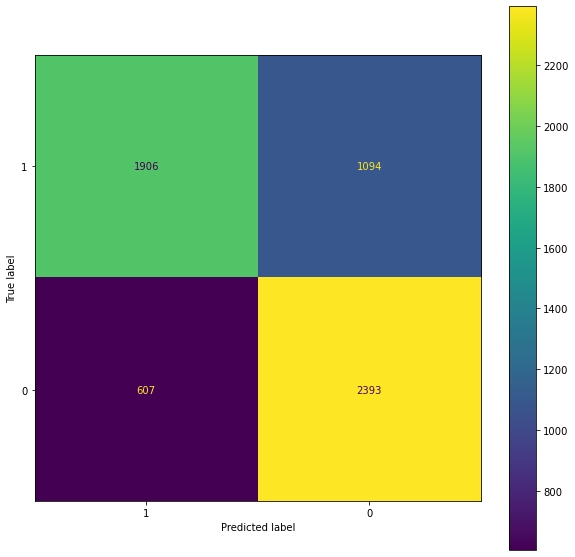

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,0])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)


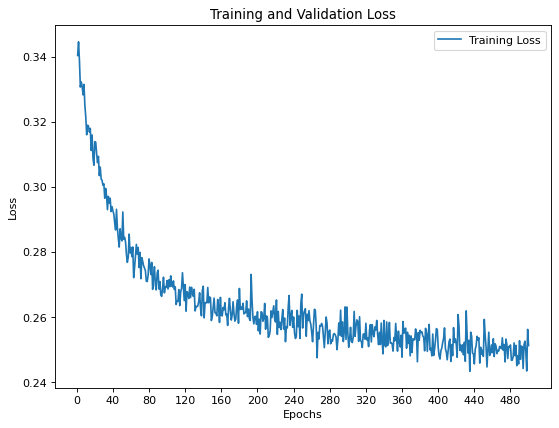

In [55]:
from matplotlib.pylab import plt
from numpy import arange
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)


 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 501)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_loss_list, label='Training Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 500 ,40))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [33]:
# len(train_loss_list)

In [66]:
len(y_pred)

128

In [56]:
plt.savefig('/home/anwer/Desktop/loss_curve.png')

<Figure size 432x288 with 0 Axes>